In [14]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
from matplotlib.ticker import FormatStrFormatter
import matplotlib.gridspec as gridspec

from gwbird import detectors
from gwbird.detectors import Observatories
from gwbird.skymap import Basis, Skymaps, PolarizationTensors
from gwbird import pls
from gwbird import snr
from gwbird.overlap import Response
from gwbird.anisotropy import AngularResponse, Sensitivity_ell
from gwbird import anisotropy
from gwbird.NANOGrav import NANOGrav_dir
from pint.models import get_model
import glob, os 
from gwbird.utils import c, H0, h


%config InlineBackend.figure_format = 'retina'

plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['font.family'] = 'serif'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Noise PSDs

Noise Power Spectral Density

```f_PSD, PSD = detectors.detector_Pn('det') ``` 

Parameters:

- det: str \
    The name of the detector to consider.
    The names must be in the list of detectors available.
    The list of available detectors can be obtained by calling the function ```detectors.available_detectors()```.
    The names of the detectors are case sensitive.

Return:
- f_PSD, PSD : array_like, array_like

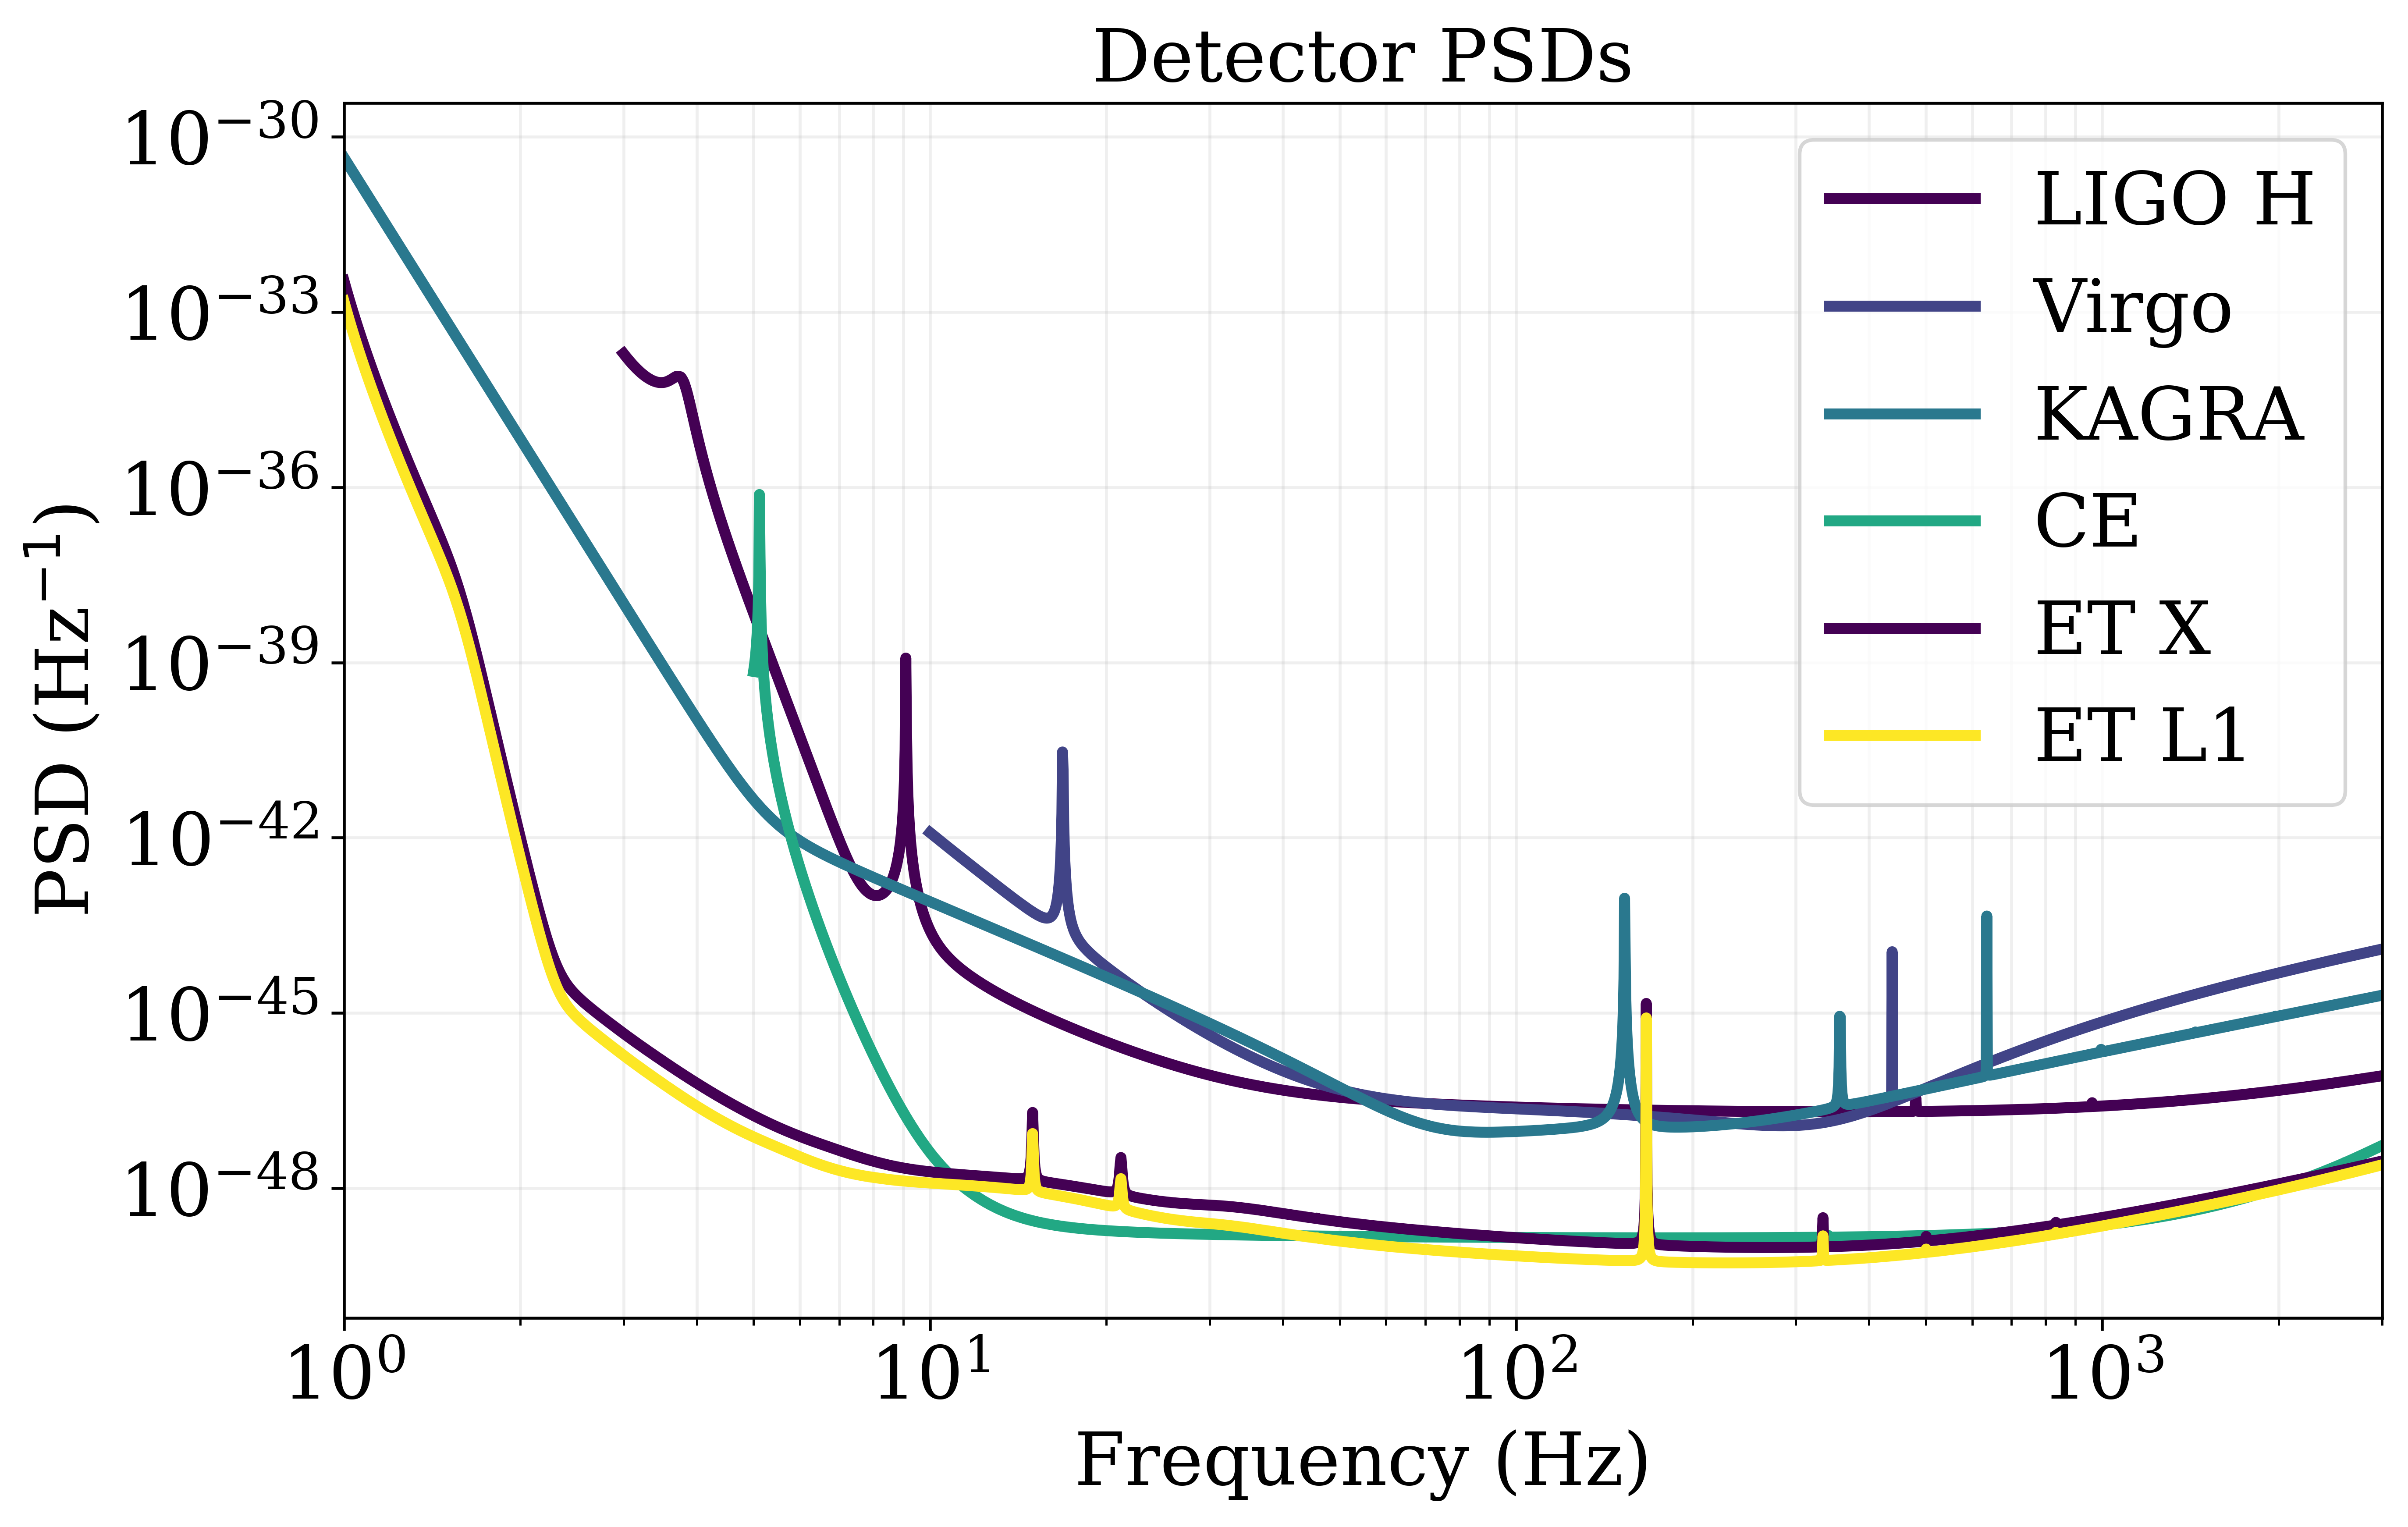

In [15]:
# Noise of different ground based detectors

f_LIGO, PSD_LIGO = detectors.detector_Pn('LIGO H')
f_Virgo, PSD_Virgo = detectors.detector_Pn('Virgo')
f_KAGRA, PSD_KAGRA = detectors.detector_Pn('KAGRA')
f_CE, PSD_CE = detectors.detector_Pn('CE')
f_ET, PSD_ET = detectors.detector_Pn('ET X')
f_ETL, PSD_ETL = detectors.detector_Pn('ET L1')

# plot

colors = cm.viridis(np.linspace(0, 1, 6))

plt.figure(figsize=(10, 6))
plt.loglog(f_LIGO, PSD_LIGO, label='LIGO H', color=colors[0])
plt.loglog(f_Virgo, PSD_Virgo, label='Virgo', color=colors[1])
plt.loglog(f_KAGRA, PSD_KAGRA, label='KAGRA', color=colors[2])
plt.loglog(f_CE, PSD_CE, label='CE', color = colors[3])
plt.loglog(f_ET, PSD_ET, label='ET X', color=colors[0])
plt.loglog(f_ETL, PSD_ETL, label='ET L1', color=colors[5])
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (Hz$^{-1}$)')
plt.title('Detector PSDs')
plt.grid(which='both', alpha=0.2)
plt.xlim(1, 3e3)
plt.legend()
plt.show()

```PSD_LISAch = detectors.LISA_noise_AET(f_LISA, channel)```

Parameters:
- f : array like (frequency array on which you want to evaluate LISA PSD)
- channel : string ('A', 'E', 'T') channel in the AET basis

Return:
- PSD_LISAch : array_like (PSD evaluated at each frequency of the array given in input for a specific channel)

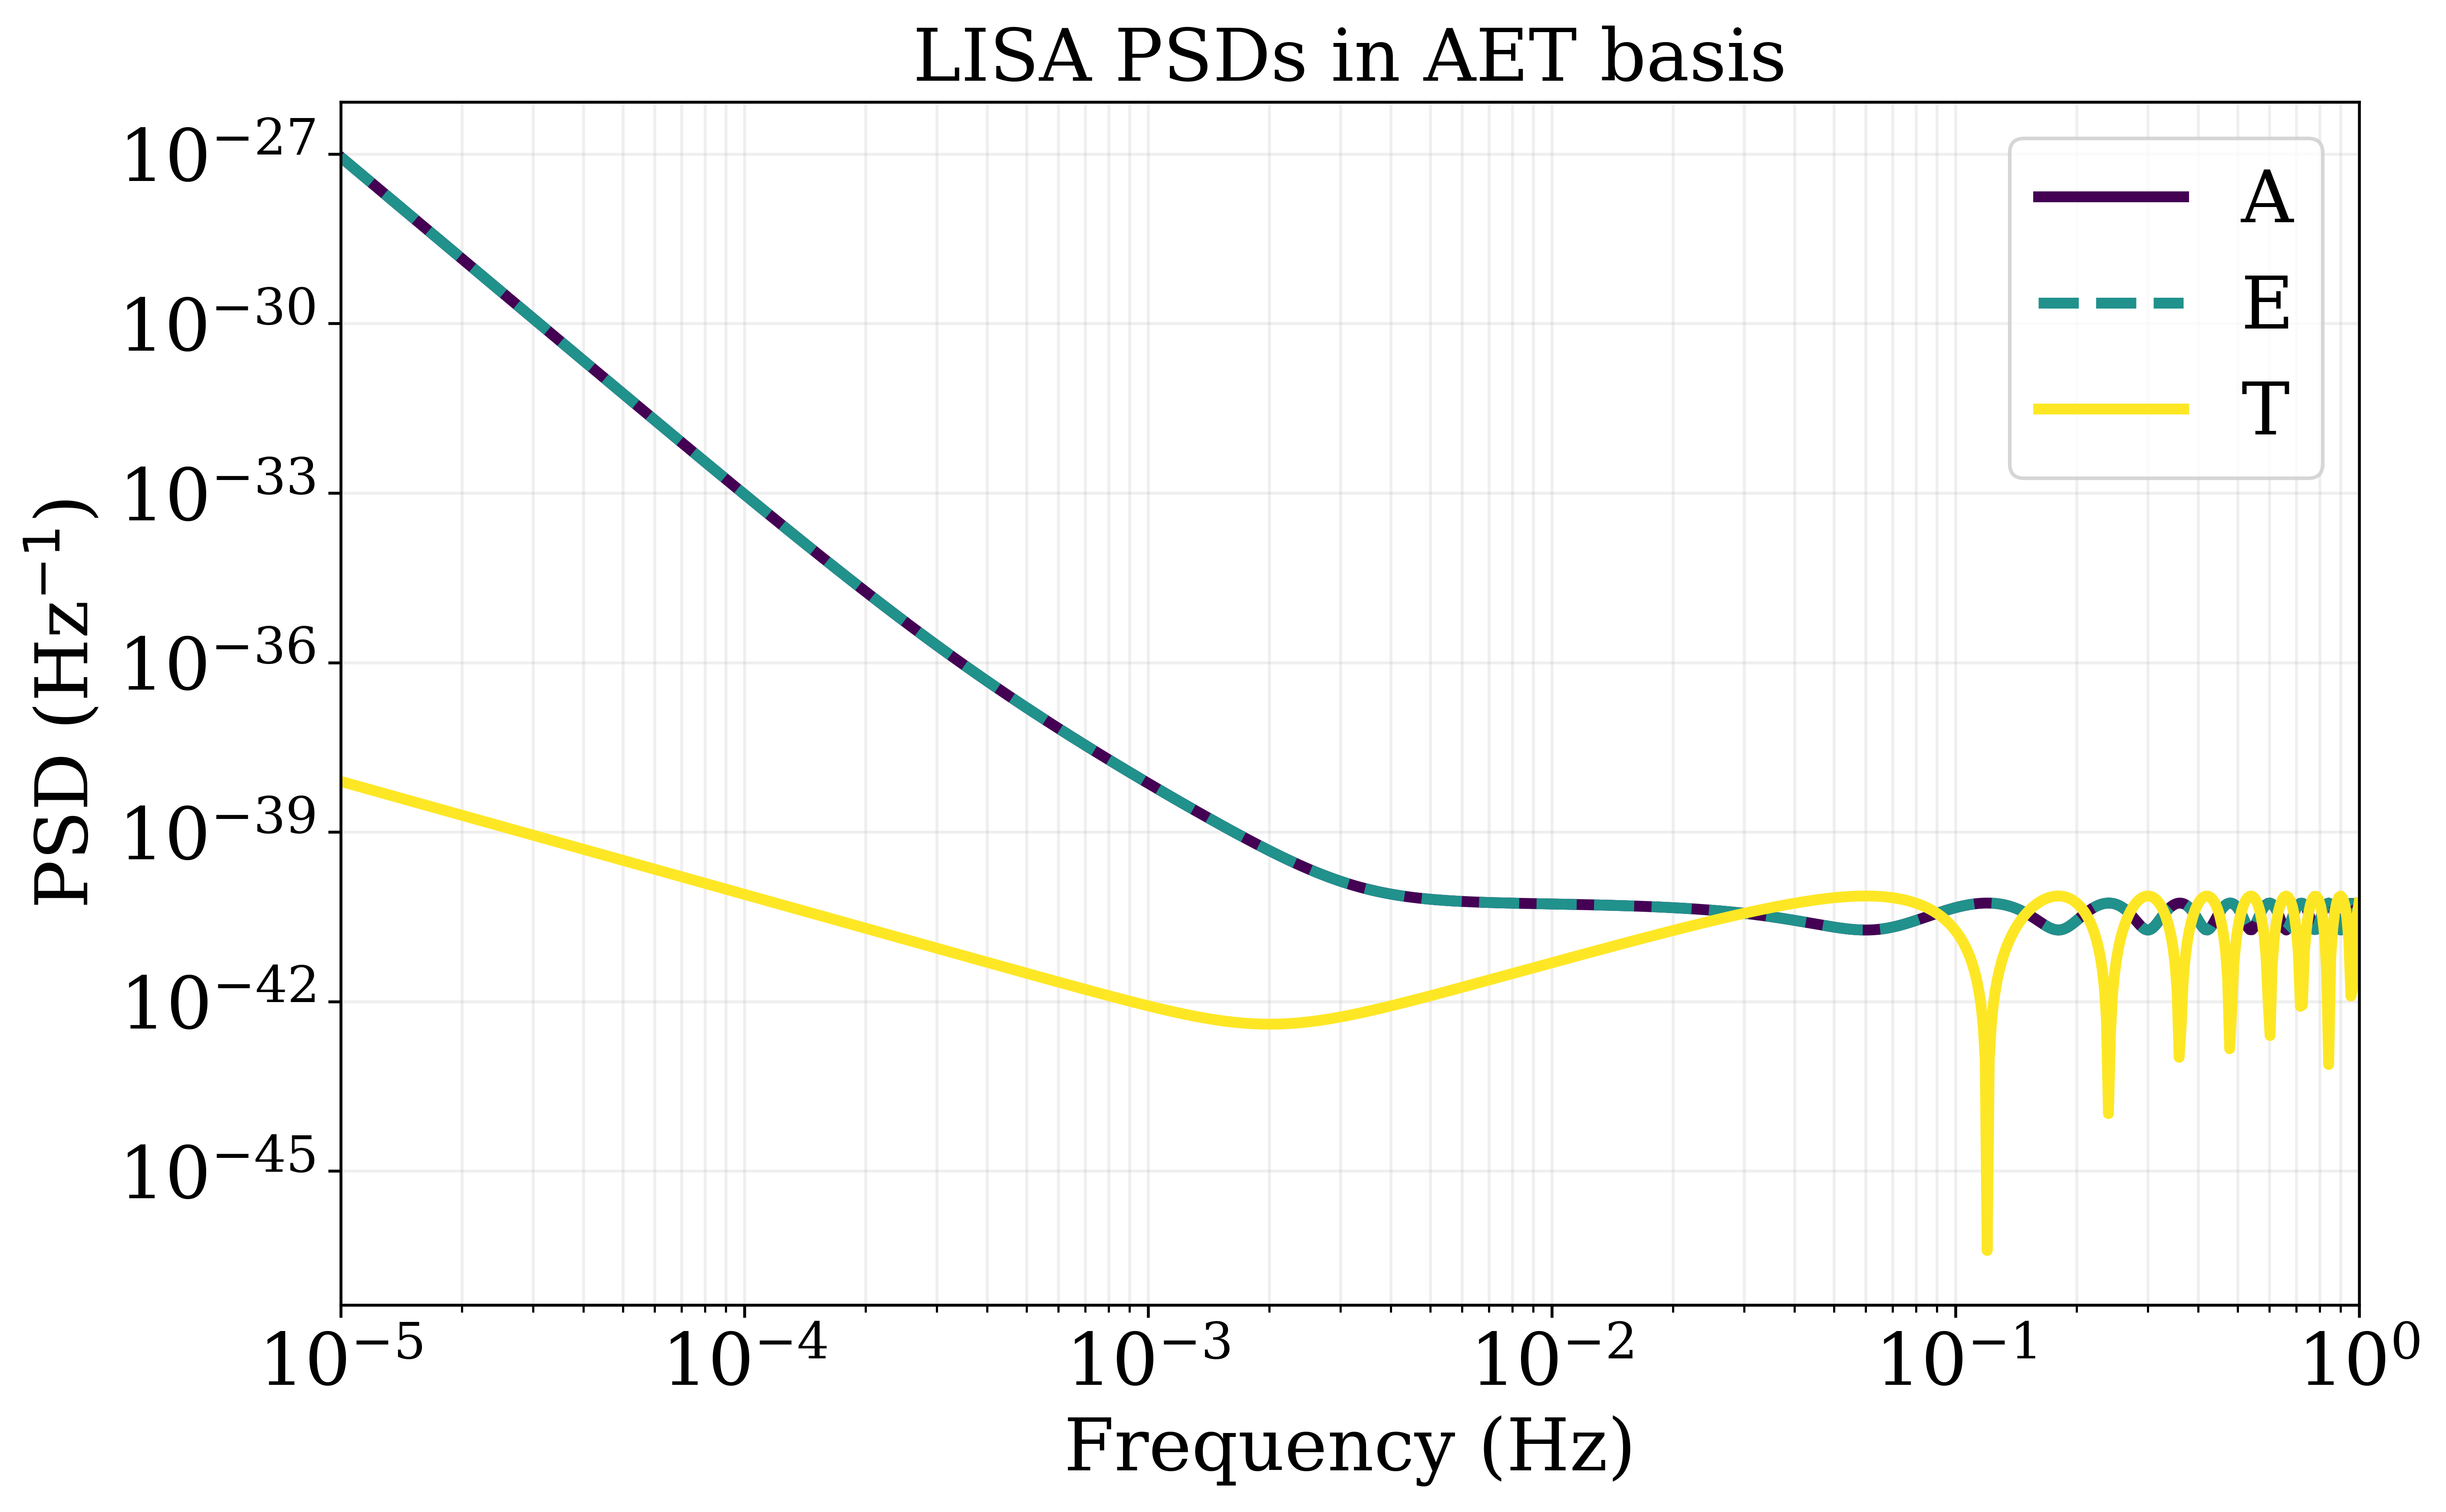

In [16]:
# Noise of LISA in the AET basis

f_LISA = np.logspace(-5, 0, 1000)
PSD_A = detectors.LISA_noise_AET(f_LISA, 'A')   
PSD_E = detectors.LISA_noise_AET(f_LISA, 'E')
PSD_T = detectors.LISA_noise_AET(f_LISA, 'T')

# plot

colors = cm.viridis(np.linspace(0, 1, 3))

plt.figure(figsize=(10, 6))
plt.loglog(f_LISA, PSD_A, label='A', color=colors[0])
plt.loglog(f_LISA, PSD_E, label='E', color=colors[1], linestyle='--')
plt.loglog(f_LISA, PSD_T, label='T', color=colors[2])
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (Hz$^{-1}$)')
plt.title('LISA PSDs in AET basis')
plt.grid(which='both', alpha=0.2)
plt.xlim(1e-5, 1)
plt.legend()
plt.show()

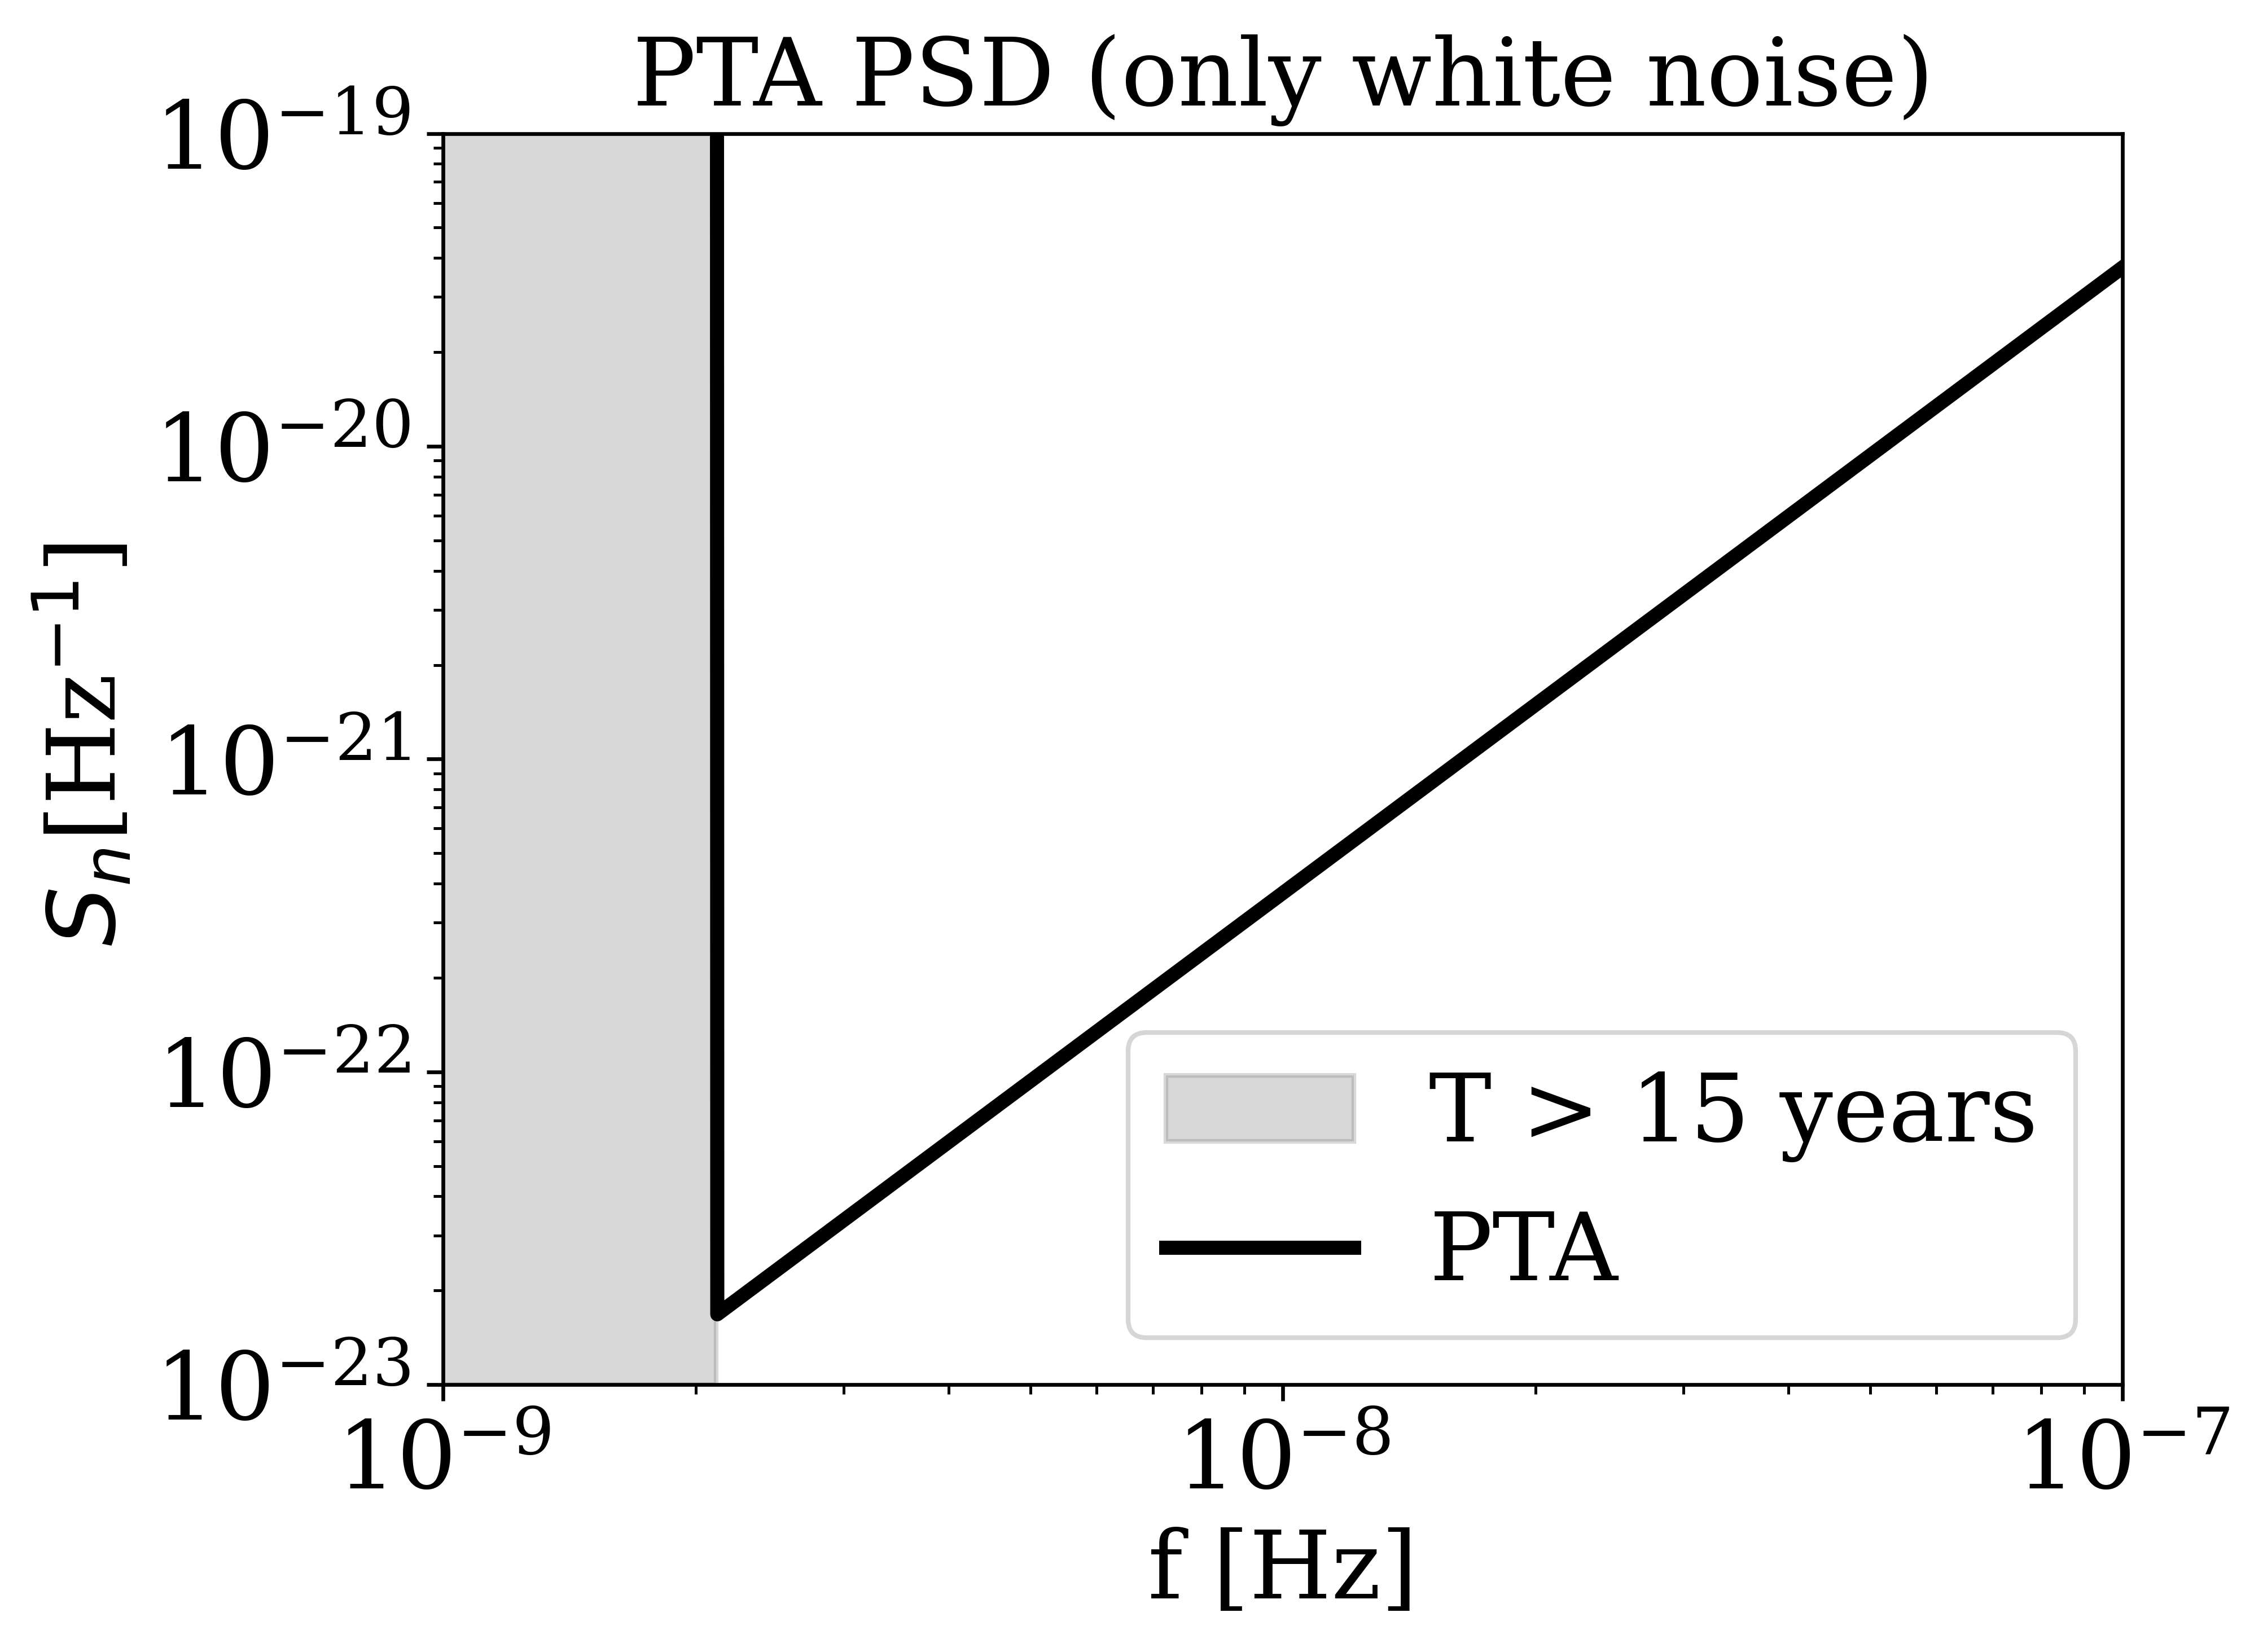

In [17]:
# Noise for PTA chosen (natively implemented in the GWBird package functions)

def PTA_Pn():
    DT = (365*24*3600)/20 # s
    s = 100 * 1e-9 #s
    return 2* (s**2) * DT

def PTA_Sn(f, Tobs):
    f = np.asarray(f) 
    mask = f>= 1/(365*24*60*60*Tobs)
    return np.where(mask, PTA_Pn() * 12 * (np.pi**2) * f**2, 1) # Apply the mask to the result

f = np.logspace(-9, -7, 1000)
T_15_years = 15 * 365 * 24 * 3600  # in s
Sn = PTA_Sn(f, 15)  
f_15_years = 1 / T_15_years  # in Hz

plt.axvspan(f.min(), f_15_years, color='gray', alpha=0.3, label='T > 15 years')
plt.plot(f, Sn, label='PTA', color='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('f [Hz]')
plt.ylabel(' $S_n $[Hz$^{-1}$]')
plt.xlim(f.min(), f.max())
plt.ylim(1e-23, 1e-19)
plt.title('PTA PSD (only white noise)')
plt.legend()
plt.show()

# Antenna Pattern maps

Antenna pattern function: detector response to an incoming GW signal

```map = Skymaps.antennapattern(det1, det2, f_ref, psi, pol, nside, shift_angle)```

Parameters:

- det1, det2: str or list of str \
    The name of the detector(s) to consider.\
    The names must be in the list of detectors available.\
    The list of available detectors can be obtained by calling the function ```detectors.available_detectors()```.\
    The names of the detectors are case sensitive.\
    If you want to provide a custom detector, you can provide the following information in a list:

    ```H = [c, xA, xB, l, name]```

    - c: array_like of length 3 (Position of the detector in the Earth-centered frame in meters)
    - xA: array_like of length 3 (Unit vector pointing towards the detector in the Earth-centered frame)
    - xB: array_like of length 3 (Unit vector pointing towards the detector in the Earth-centered frame)
    - l: float (Length of the arm in meters)
    - name: str (Name of the detector)

- f: frequency array

- psi: polarization angle in [0, pi]

- pol: polarization type: 't', 'v', 's', 'I', 'V'

- nside: int, optional\
    The nside parameter for the healpy function. Default is 32.

- shift_angle: float, optional\
    The separation angle between ET L Sardinia - ET L The Netherlands. Default is None.

Returns:
- map: array_like (npix)


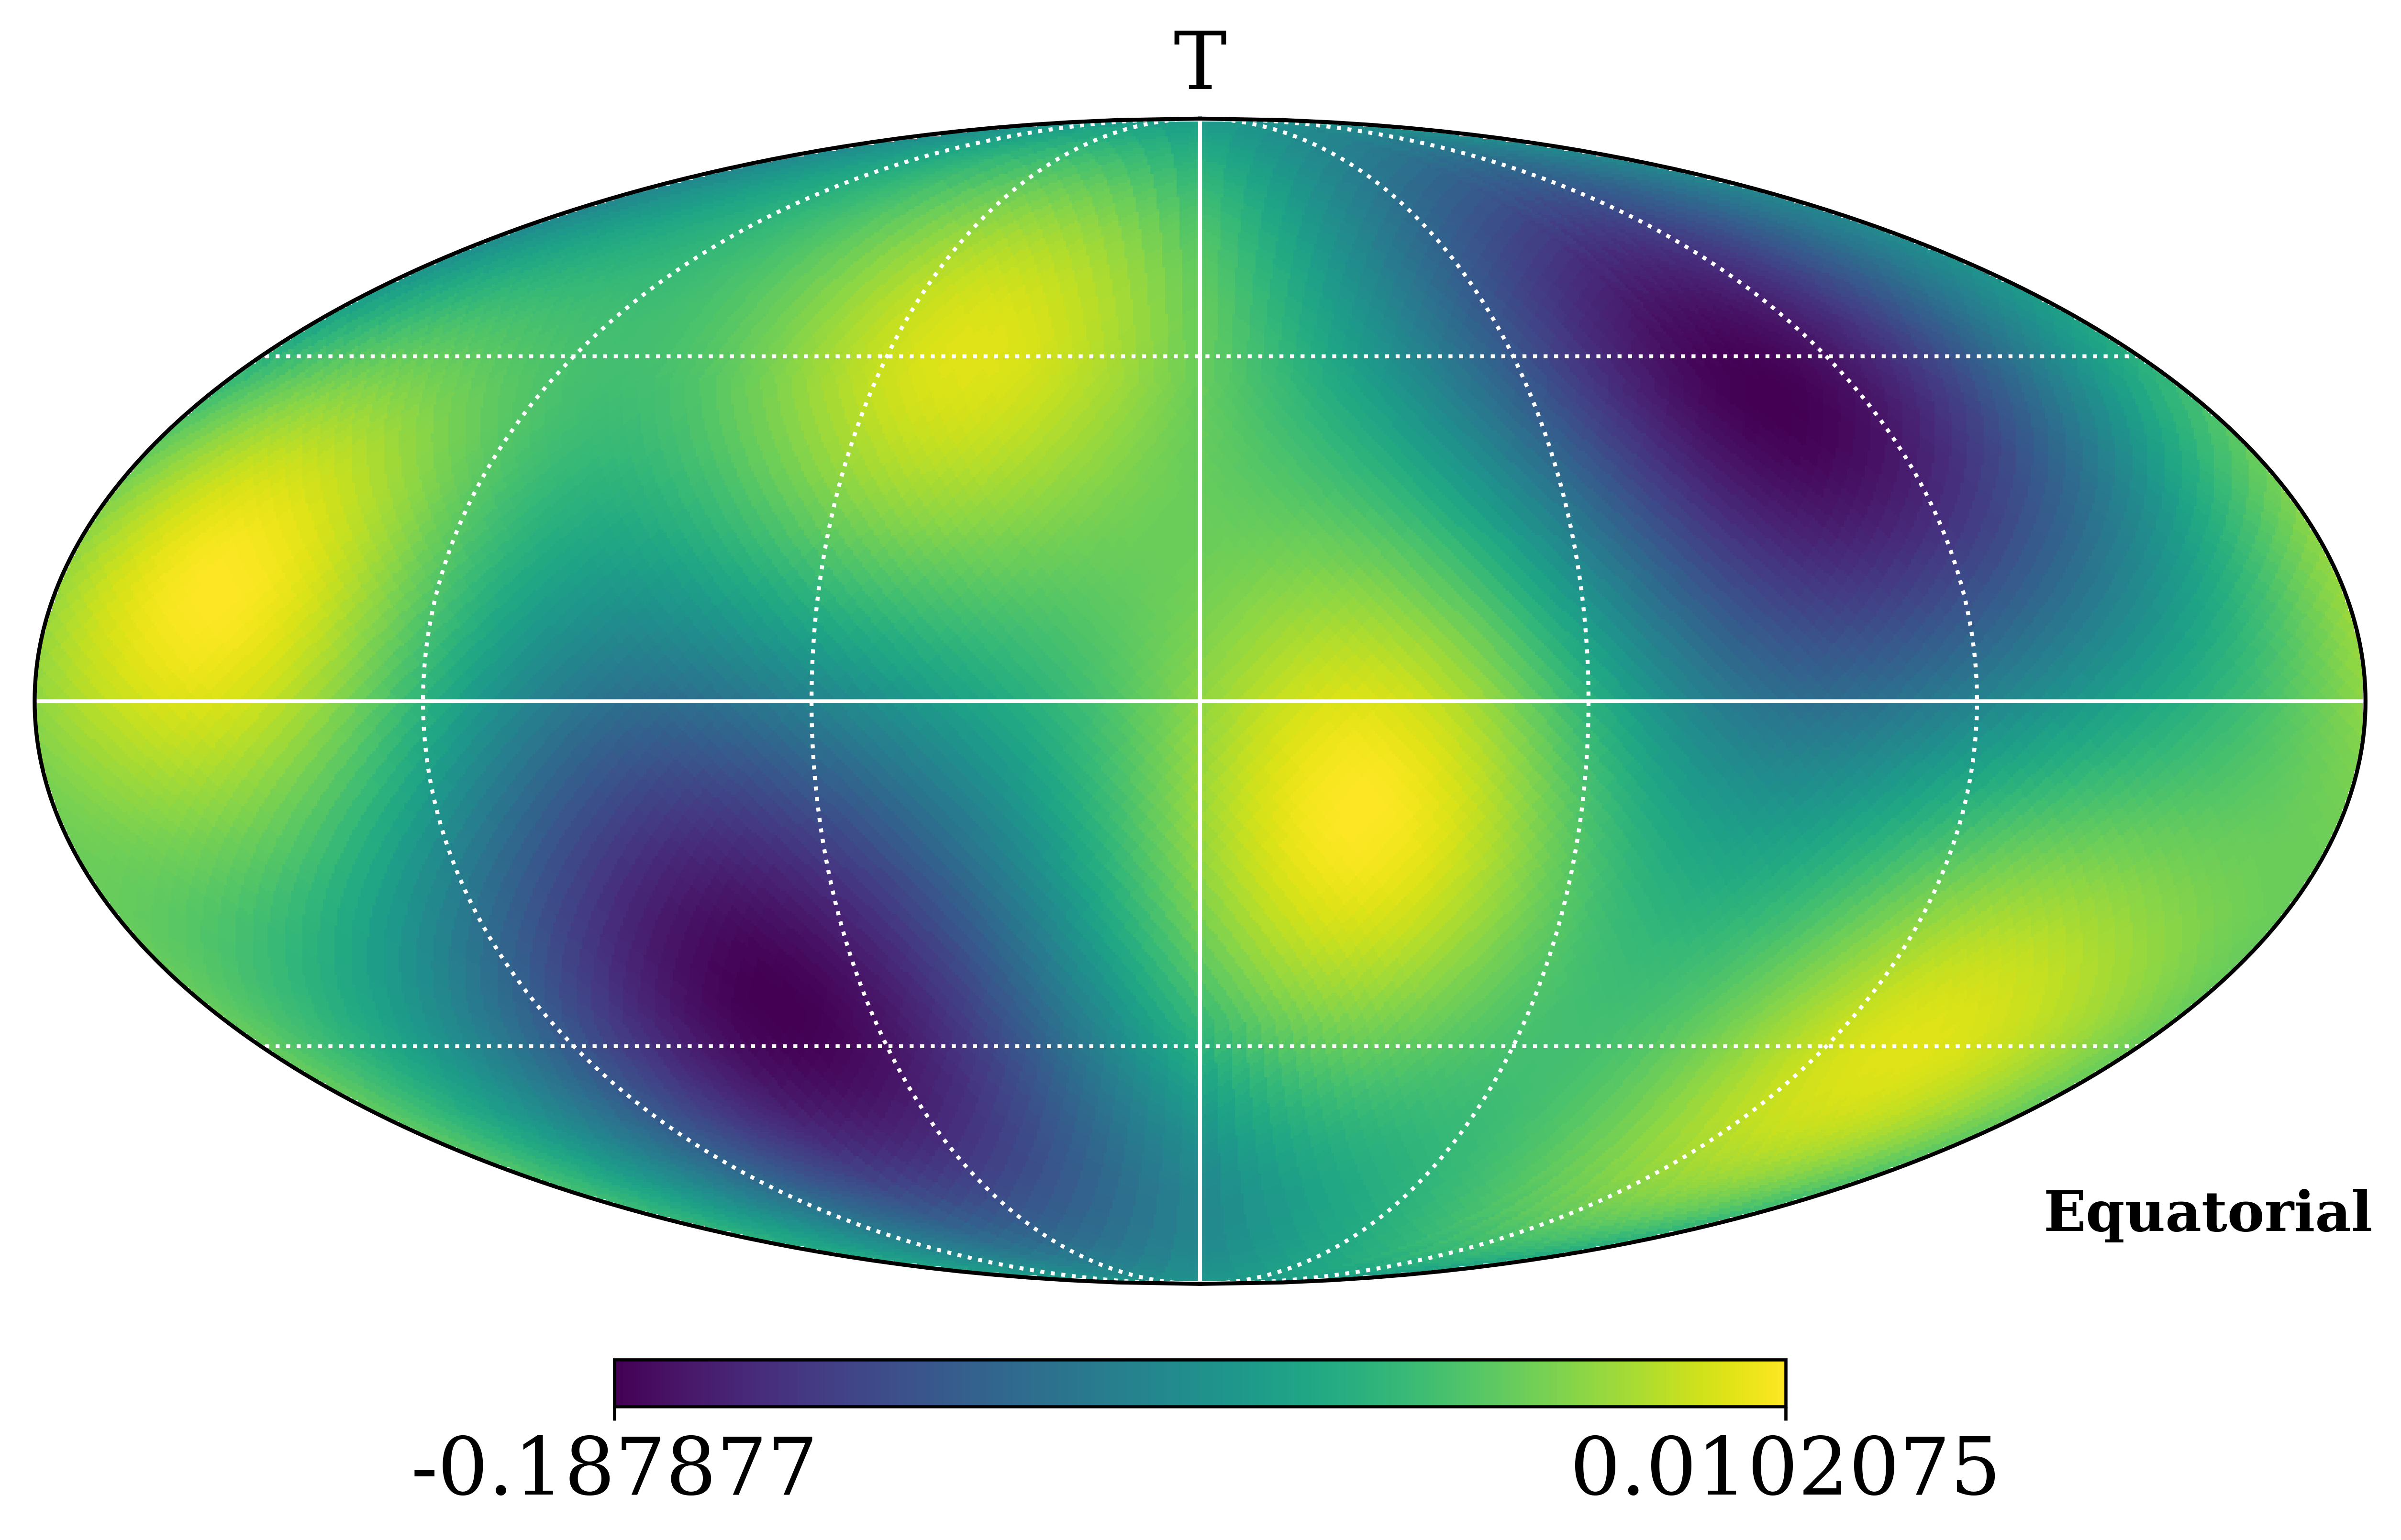

In [18]:
mapHL = Skymaps.antennapattern('LIGO H', 'LIGO L', 10, 0, 't')

# Overlap Reduction Function

## Ground Based Detectors


Compute the overlap reduction function between two detectors.

```R = Response.overlap(det1, det2, f, pol, psi, shift_angle=False)```

Parameters:
- det1, det2: str or list of str \
    The name of the detector(s) to consider.\
    The names must be in the list of detectors available in the response module.\
    The list of available detectors can be obtained by calling the function ```detectors.available_detectors()```.\
    The names of the detectors are case sensitive.\
    If you want to provide a custom detector, you can provide the following information in a list:

    ```H = [c, xA, xB, l, name]```

    - c: array_like of length 3 (Position of the detector in the Earth-centered frame in meters)
    - xA: array_like of length 3 (Unit vector pointing towards the detector in the Earth-centered frame)
    - xB: array_like of length 3 (Unit vector pointing towards the detector in the Earth-centered frame)
    - l: float (Length of the arm in meters)
    - name: str (Name of the detector)

- f: array_like (Frequency in Hz)
- pol: str (Polarization of the signal, 't' for tensor, 'v' for vector, 's' for scalar, 'I' for tensor intensity stokes parameter, 'V' for tensor circular polarization stokes parameter )
- psi: float (Polarization angle in radians)

Optional parameters:
- shift_angle: bool or float (Shift the angle of the response if considering ET 2L in radians)

Return:
- overlap: array_like (Overlap reduction function between the two detectors)




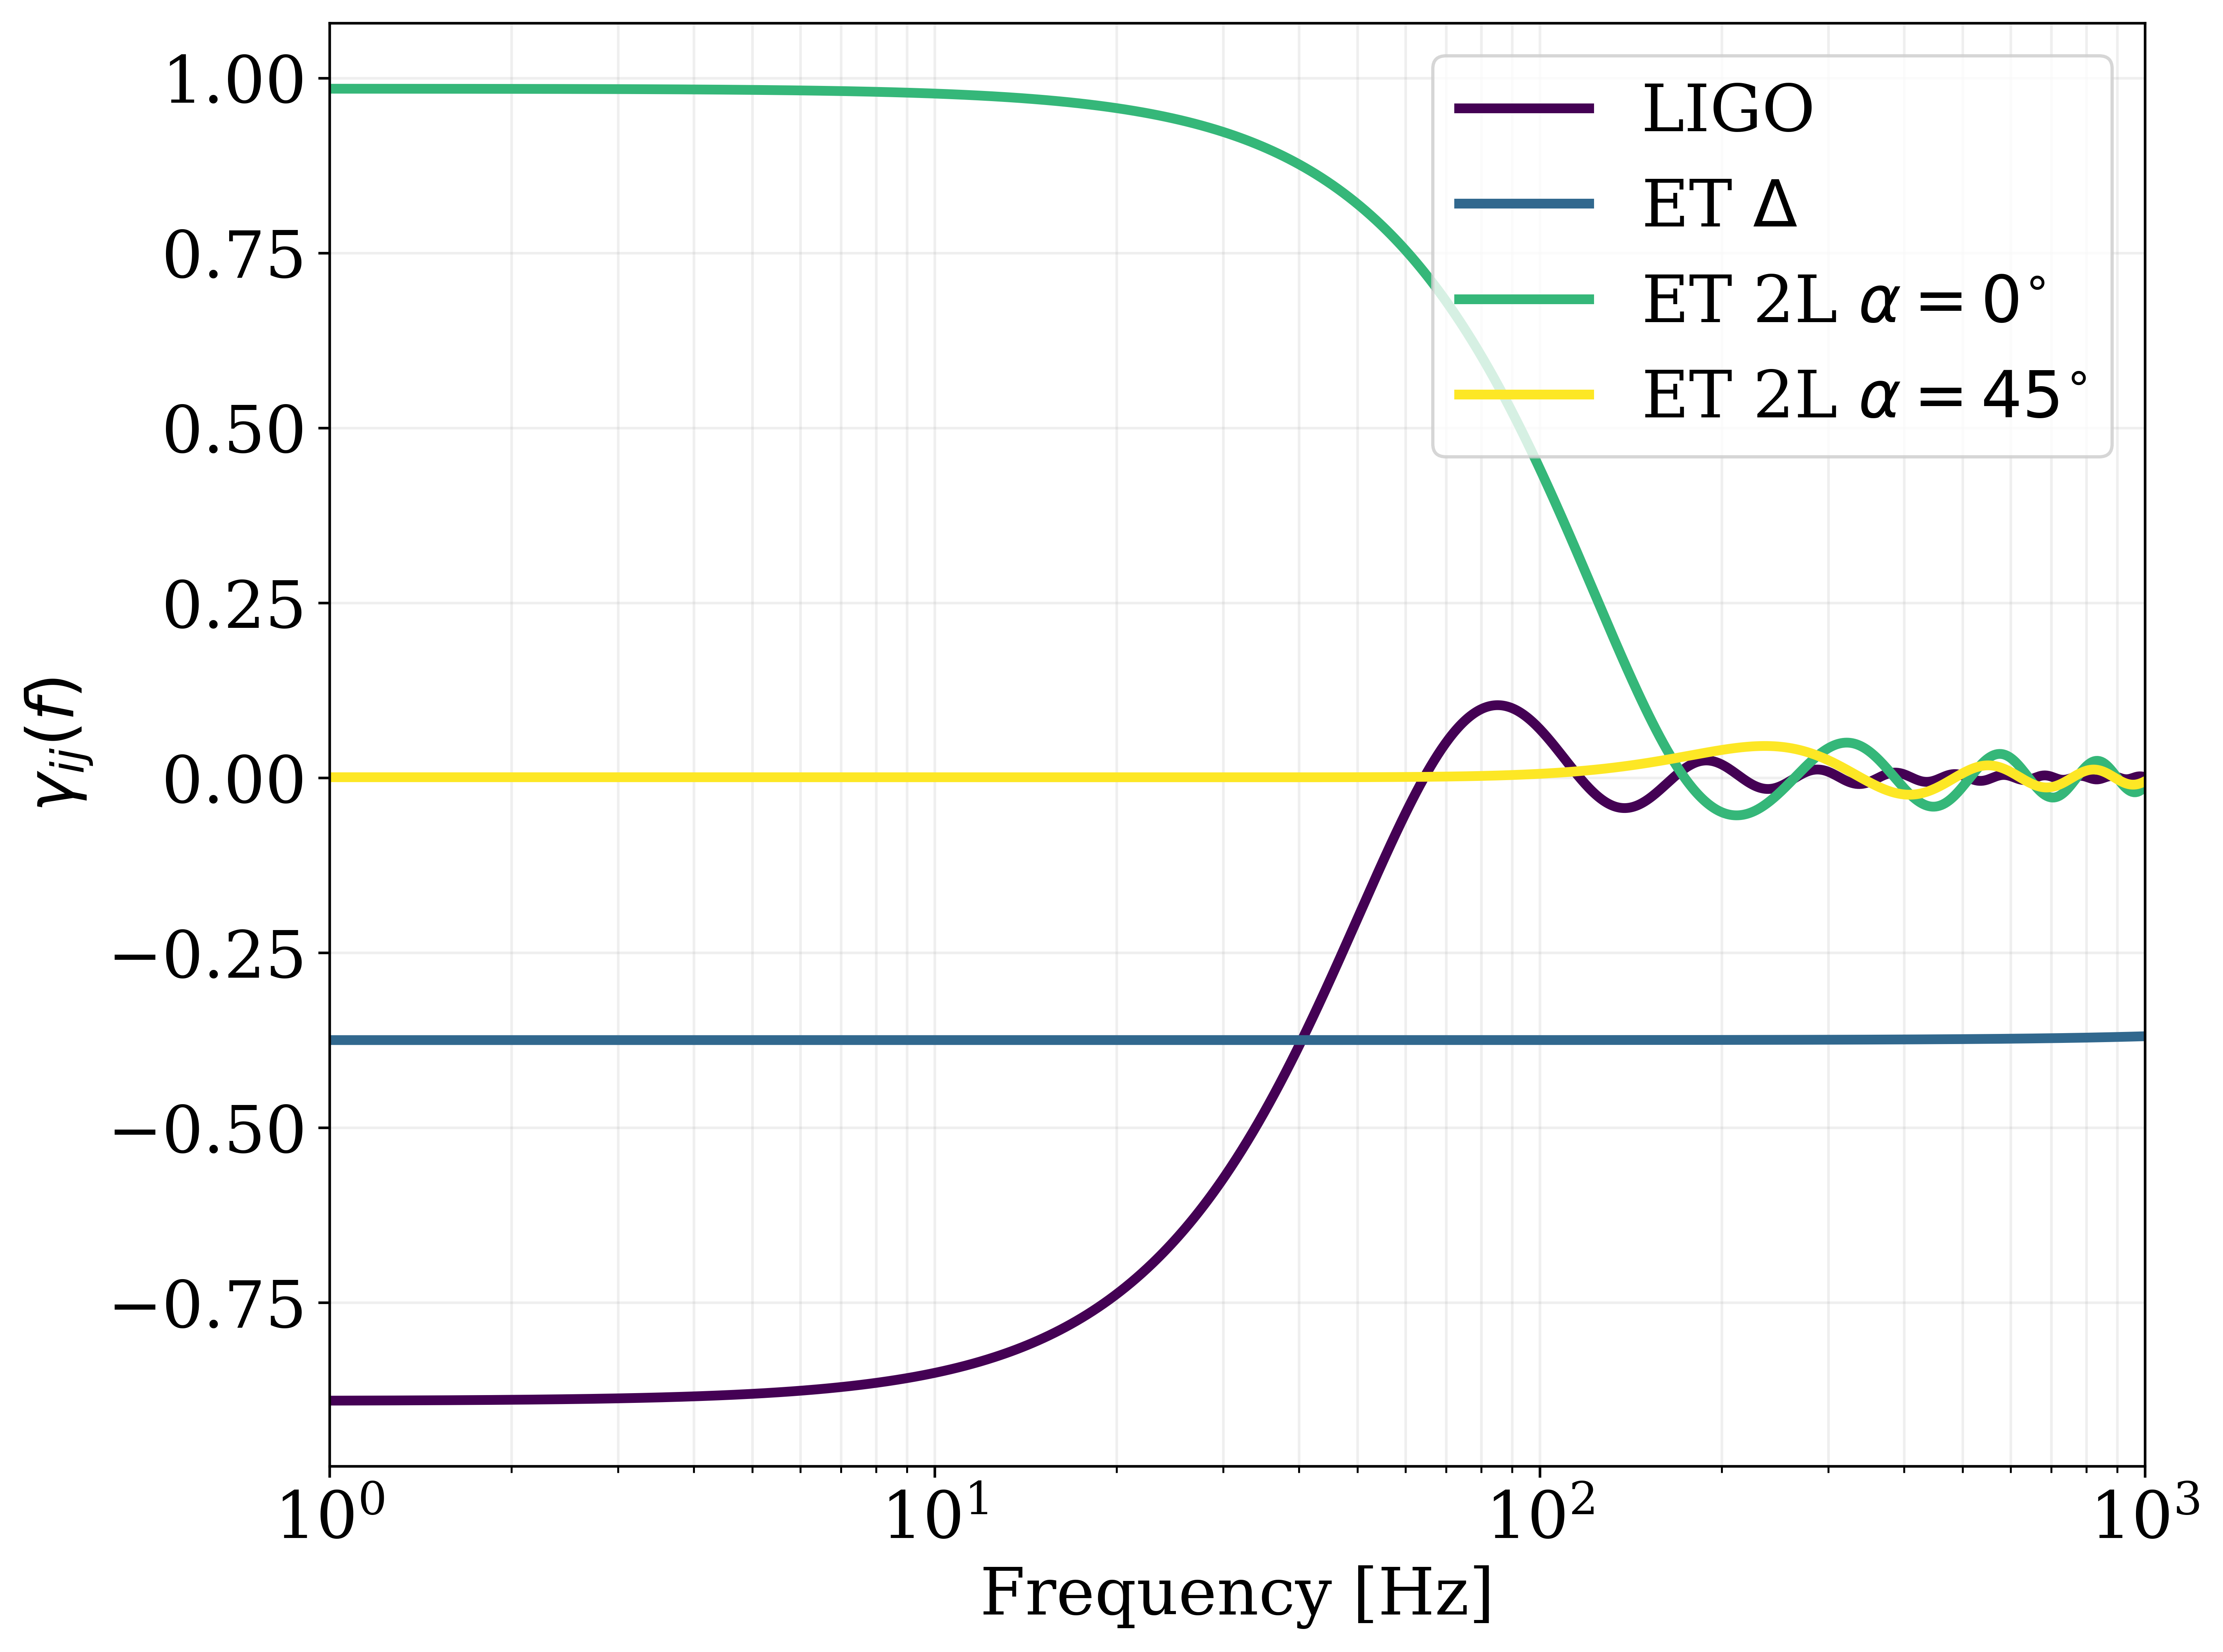

In [19]:
f = np.logspace(0, 3, 1000)
R_LIGO = Response.overlap('LIGO H', 'LIGO L', f, 't', 0,  None)
R_ET    = Response.overlap('ET X', 'ET Y', f, 't', 0,  None)
R_ET2L0 = Response.overlap('ET L1', 'ET L2', f,'t', 0, shift_angle=0)
R_ET2L45 = Response.overlap('ET L1', 'ET L2', f, 't', 0, shift_angle=np.pi/4)

colors = cm.viridis(np.linspace(0, 1, 4))

plt.figure(figsize=(10, 8))
plt.plot(f, R_LIGO, label='LIGO', color=colors[0])
plt.plot(f, R_ET, label=r'ET $\Delta$', color=colors[1])
plt.plot(f, R_ET2L0, label=r'ET 2L $\alpha=0^{\circ}$', color=colors[2])
plt.plot(f, R_ET2L45, label=r'ET 2L $\alpha=45^{\circ}$', color=colors[3])
plt.xscale('log')
plt.ylabel(r'$\gamma_{ij}(f)$')
plt.xlabel('Frequency [Hz]')
plt.xlim(f.min(), f.max())
plt.legend()
plt.grid(which='both', alpha=0.2)
plt.show()

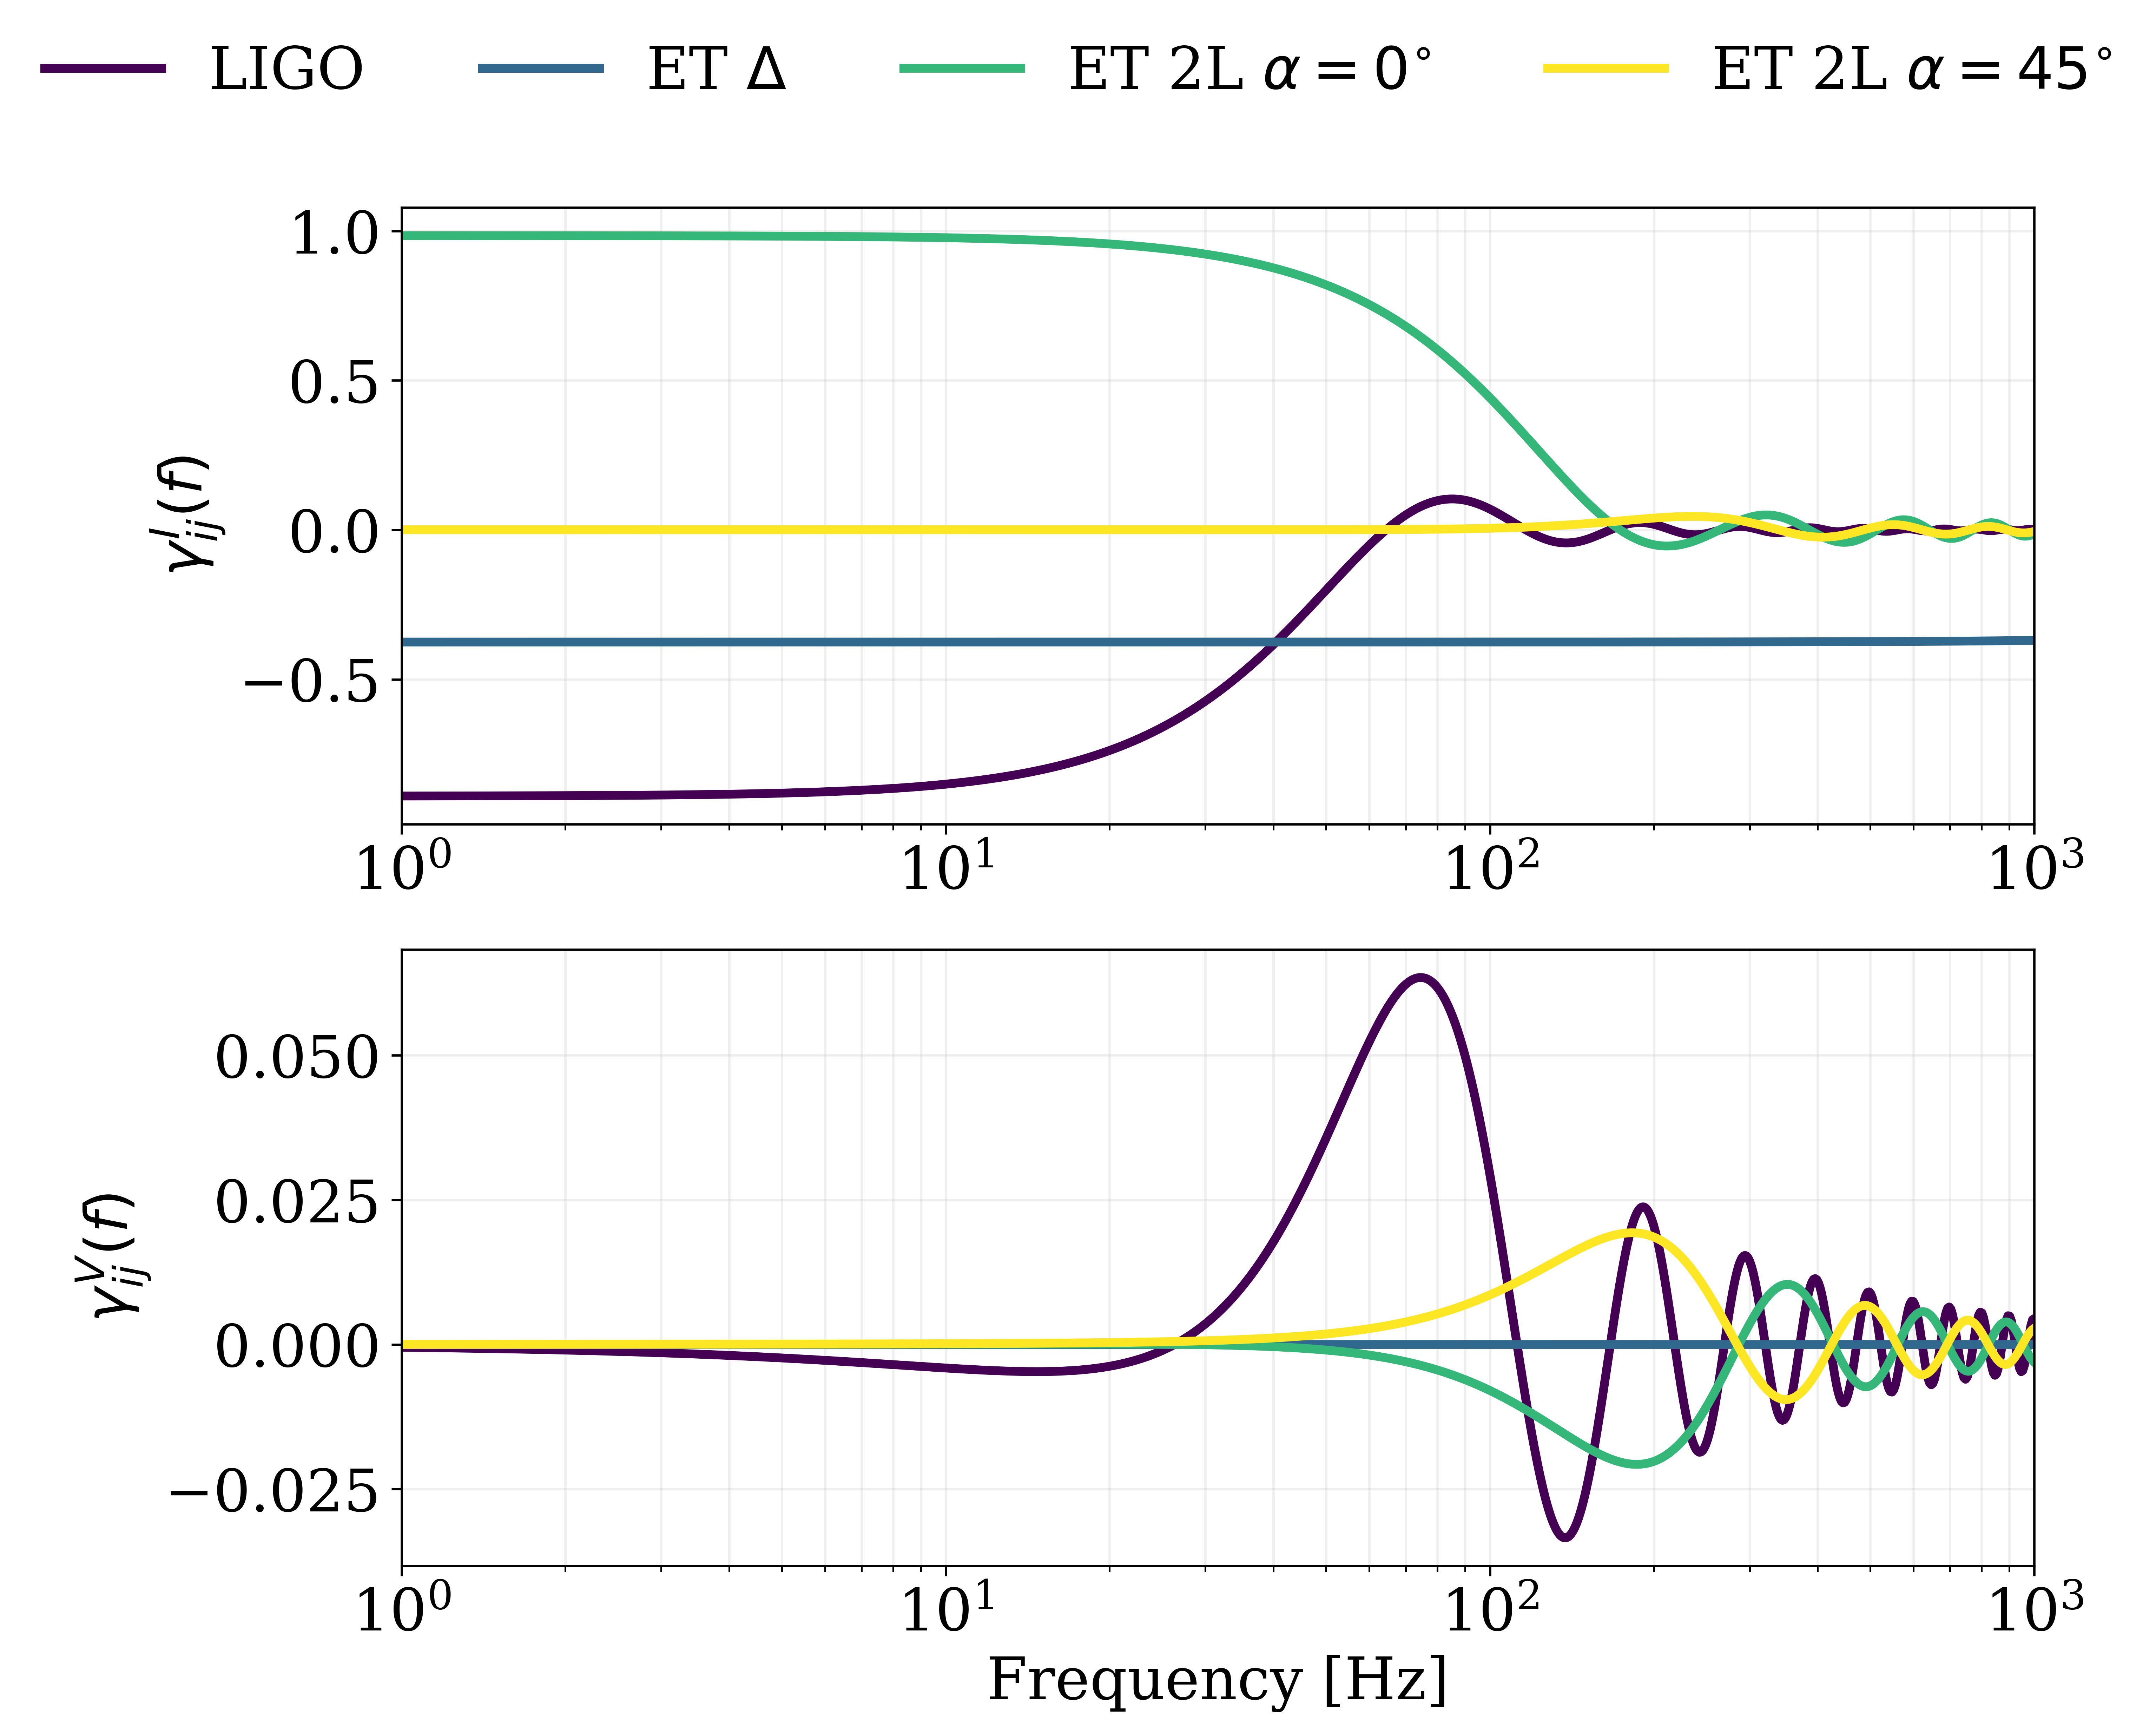

In [7]:
# example of the overlap function for the I and V stokes parameter

f = np.logspace(0, 3, 1000)
R_LIGO_I = Response.overlap('LIGO H', 'LIGO L', f, 'I', 0,  None)
R_LIGO_V = Response.overlap('LIGO H', 'LIGO L', f, 'V', 0, None) # agreement with https://arxiv.org/pdf/1212.4165, fig.1
R_ET_I    = Response.overlap('ET X', 'ET Y', f, 'I', 0,  None)
R_ET_V    = Response.overlap('ET X', 'ET Y', f, 'V', 0, None)
R_ET2L0_I = Response.overlap('ET L1', 'ET L2', f, 'I', 0, shift_angle=0)
R_ET2L0_V = Response.overlap('ET L1', 'ET L2', f, 'V', 0, shift_angle=0)
R_ET2L45_I = Response.overlap('ET L1', 'ET L2', f, 'I', 0, shift_angle=np.pi/4)
R_ET2L45_V = Response.overlap('ET L1', 'ET L2', f, 'V', 0, shift_angle=np.pi/4)

plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)

plt.plot(f, R_LIGO_I, label='LIGO', color=colors[0])
plt.plot(f, R_ET_I, label=r'ET $\Delta$', color=colors[1])
plt.plot(f, R_ET2L0_I, label=r'ET 2L $\alpha=0^{\circ}$', color=colors[2])
plt.plot(f, R_ET2L45_I, label=r'ET 2L $\alpha=45^{\circ}$', color=colors[3])
plt.xscale('log')
plt.ylabel(r'$\gamma_{ij}^I(f)$')
plt.xlim(f.min(), f.max())
plt.grid(which='both', alpha=0.2)

plt.subplot(2, 1, 2)
plt.plot(f, R_LIGO_V, color=colors[0])
plt.plot(f, R_ET_V, color=colors[1])
plt.plot(f, R_ET2L0_V, color=colors[2])
plt.plot(f, R_ET2L45_V, color=colors[3])
plt.xlabel('Frequency [Hz]')
plt.xscale('log')
plt.ylabel(r'$\gamma_{ij}^V(f)$')
plt.xlim(f.min(), f.max())
plt.grid(which='both', alpha=0.2)


lines_labels = [ax.get_legend_handles_labels() for ax in plt.gcf().axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

intensity_labels = ['LIGO', r'ET $\Delta$', r'ET 2L $\alpha=0^{\circ}$', r'ET 2L $\alpha=45^{\circ}$']
filtered_lines_labels = [(line, label) for line, label in zip(lines, labels) if label in intensity_labels]

if filtered_lines_labels:
    lines, labels = zip(*filtered_lines_labels)
else:
    lines, labels = [], []

if lines and labels:
    plt.figlegend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## LISA

For triangular detector, like ET and LISA, it is available to consider their combination in the AET basis. 

In the case of ET, this is specifically useful in the presence of correlated noise. 

You can type 'ET' or 'LISA' + space + 'A', 'E', 'T'.

Invalid combination of channels is properly handled. 

* Note: we do not adopt the convention by which $\gamma_{ij}$ is normalized by $1/4\pi$ for LISA but we normalize it as all the other detectors to $5/8\pi$. If you wish to be consistent with the notation in  https://arxiv.org/abs/2201.08782, divide the result by 2/5. Remember however that the sensitivity curves will not be affected by any multiplicative factor, as it is taken into account in the code. 

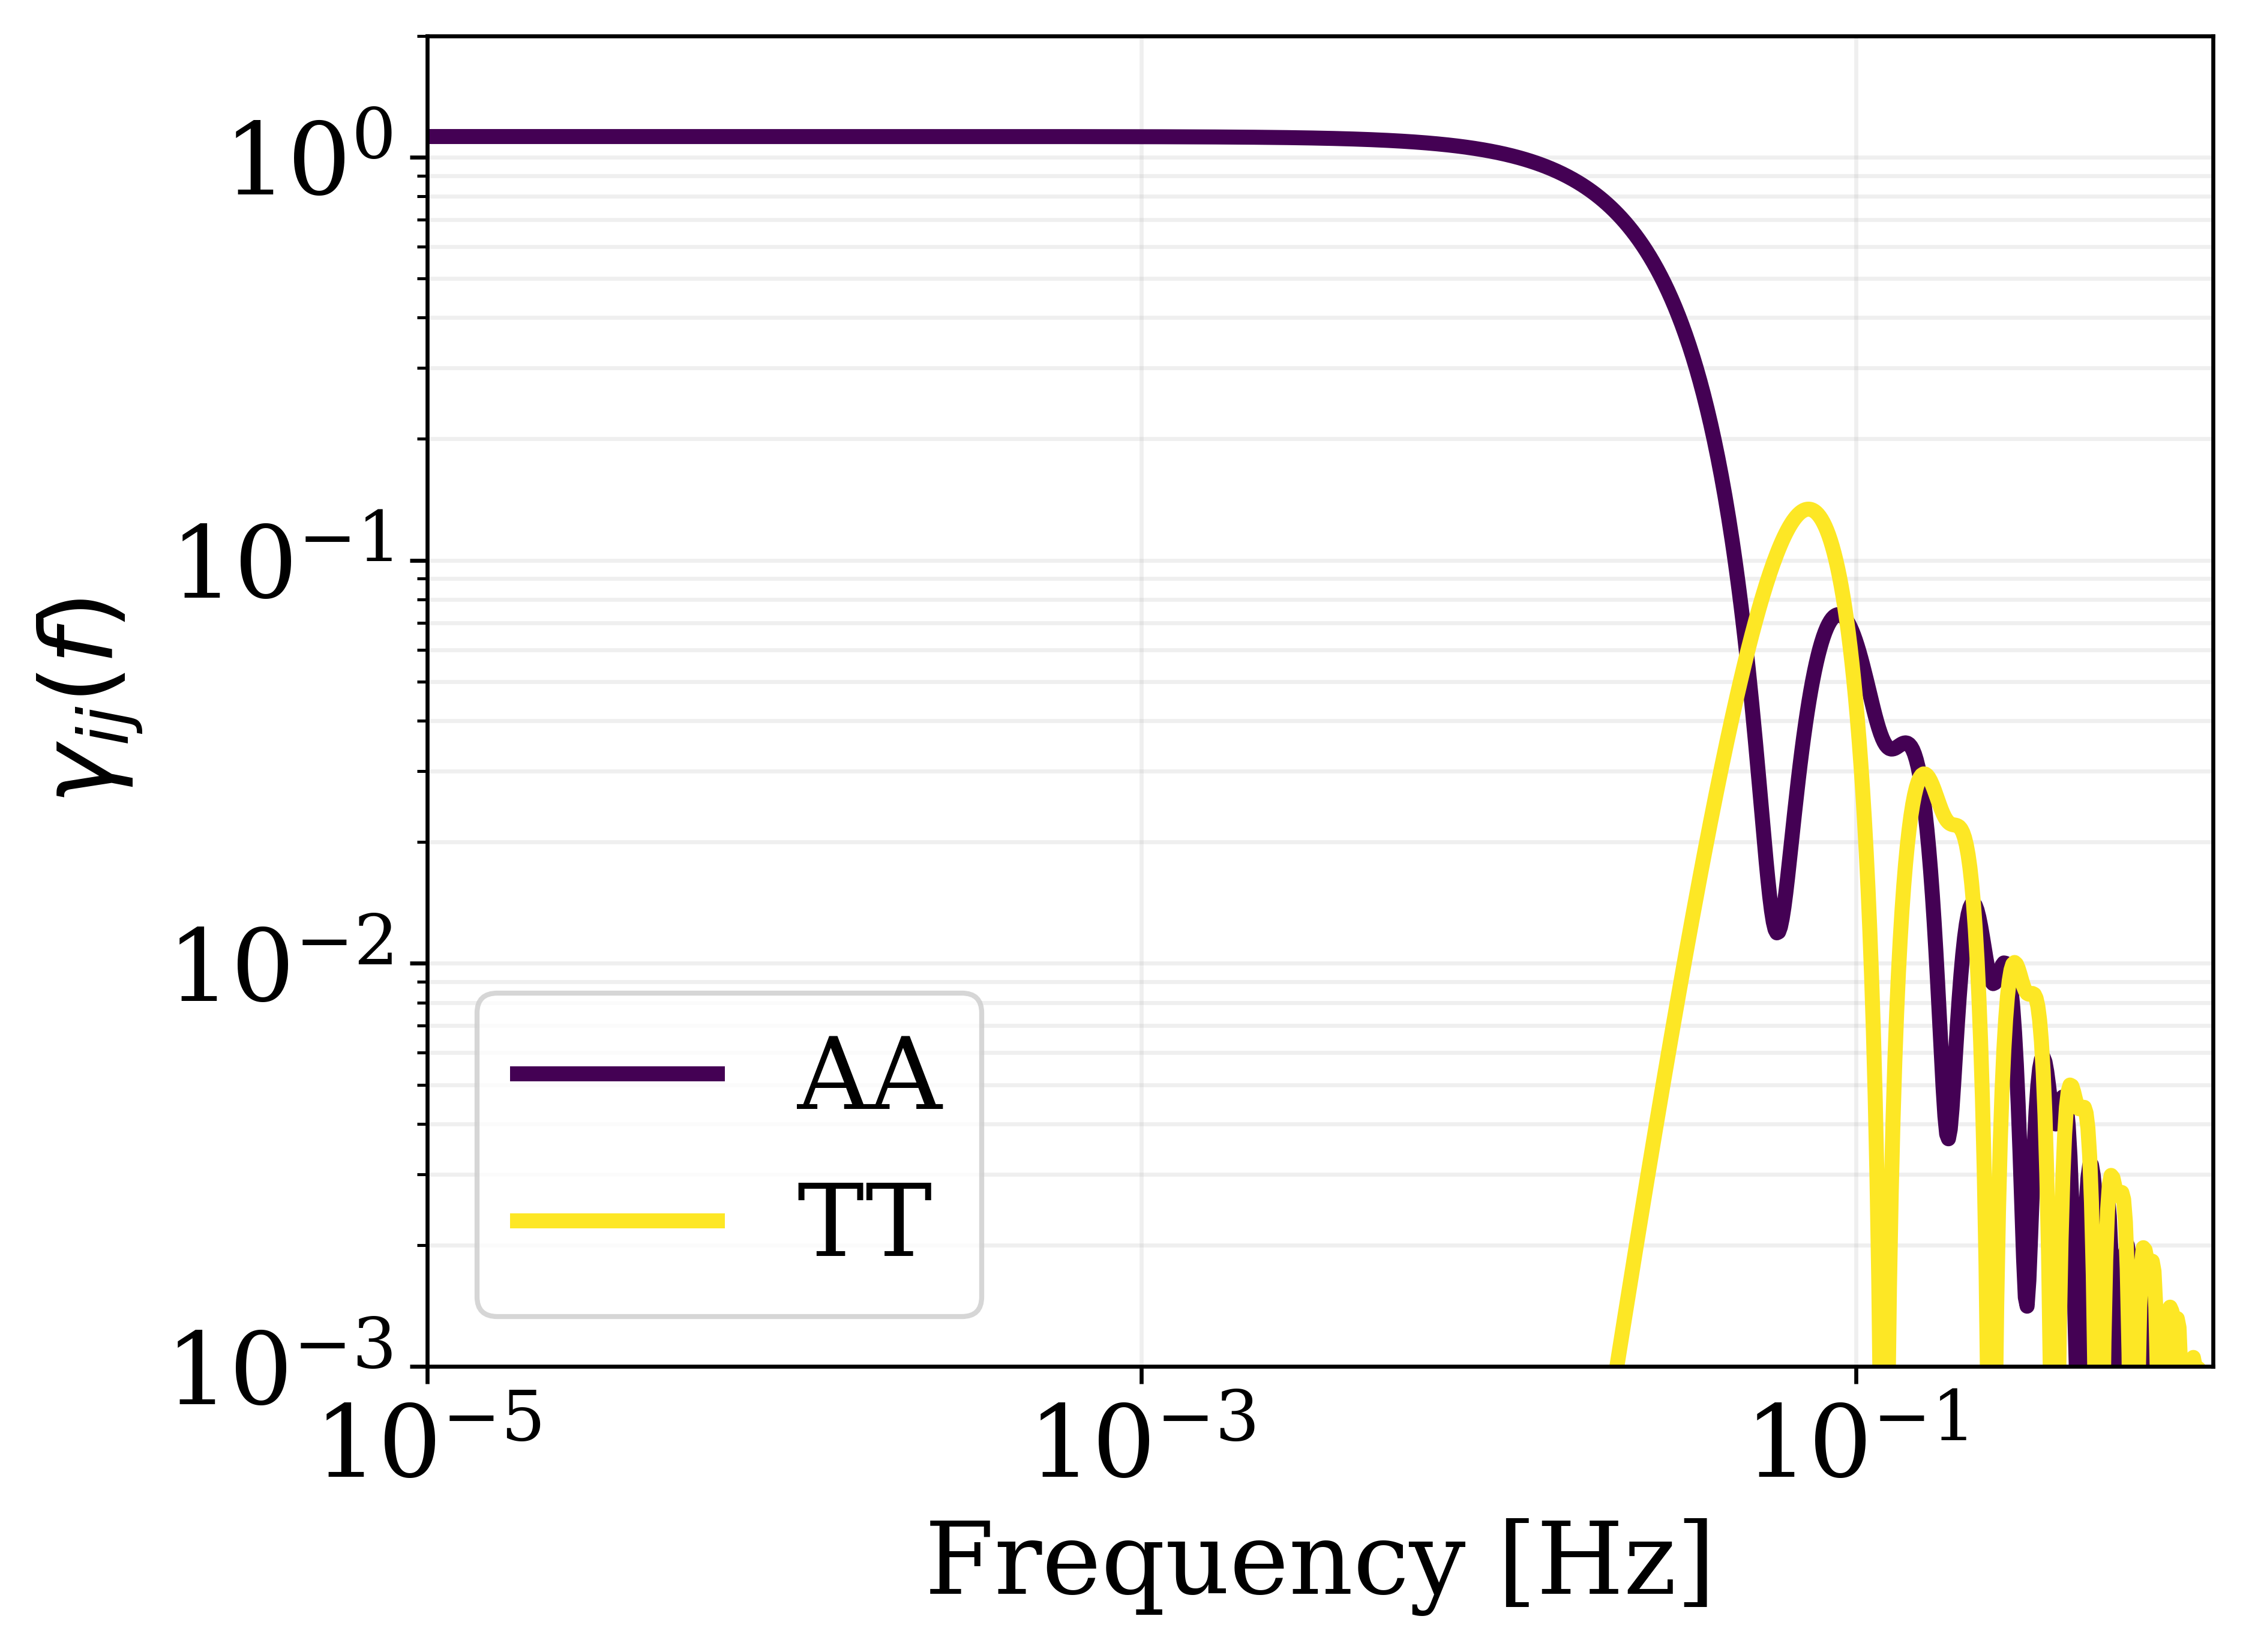

In [8]:
f_lisa = np.logspace(-5, 0, 1000)
R_AA = Response.overlap('LISA A', 'LISA A', f_lisa, 't', 0)
R_TT = Response.overlap('LISA T', 'LISA T', f_lisa, 't', 0)

colors = cm.viridis(np.linspace(0, 1, 2))

plt.figure()
plt.plot(f_lisa, R_AA, label='AA', color=colors[0])
plt.plot(f_lisa, R_TT, label='TT', color=colors[1])
plt.xlabel('Frequency [Hz]')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$\gamma_{ij}(f)$')
plt.xlim(f_lisa.min(), f_lisa.max())
plt.ylim(1e-3, 2)
plt.grid(which='both', alpha=0.2)
plt.legend()
plt.show()

# Pulsar Timing Array

Calculate the overlap reduction function for a catalog of pulsars.
The one we choose is https://zenodo.org/records/14773896.

However, if you wish to consider another catalog, you can modify the detectors.py module. 
Suggestion: build a function in the detectors.py module that returns:
- the number of pulsars
- the pulsars directions in the xyz coordinates (normalized!)
- the pulsars distances.

Keep in mind that the overlap functions take into account the pulsar distance. If you want to avoid this (since the pulsars distances present  high uncertainties), you have to modify pairwise_overlap and overlap_PTA in the overlap.py module.
We suggest you do to this only for tensor and breathing scalar modes. As mentioned in https://arxiv.org/abs/1111.5661 the pulsar term contributions affect longitudinal polarization modes.

Tipical usage (if you don't want to modify anything):

``` gamma_ij_t[i] = Response.overlap_pairwise(f, pulsar_xyz[i], pulsar_xyz[j], d[i], d[j], 't', psi)```

Compute the overlap reduction function between two pulsars

Parameters:
- f: array_like (Frequency in Hz)
- pi: len(3) array_like (Position of the first pulsar)
- pj: len(3) array_like (Position of the second pulsar)
- pol: str (Polarization of the signal, 't' for tensor, 'v' for vector, 's' for scalar breathing, 'l' for scalar longitudinal, 'I' for intensity, 'V' for circular)
- psi: float, (Polarization angle in radians, default is 0)

Return:
- overlap: array_like (Overlap reduction function between two pulsars)





2025-07-15 15:08:22.718 | DEBUG    | pint.models.binary_ddk:validate:211 - Validating DDK model in ECL coordinates


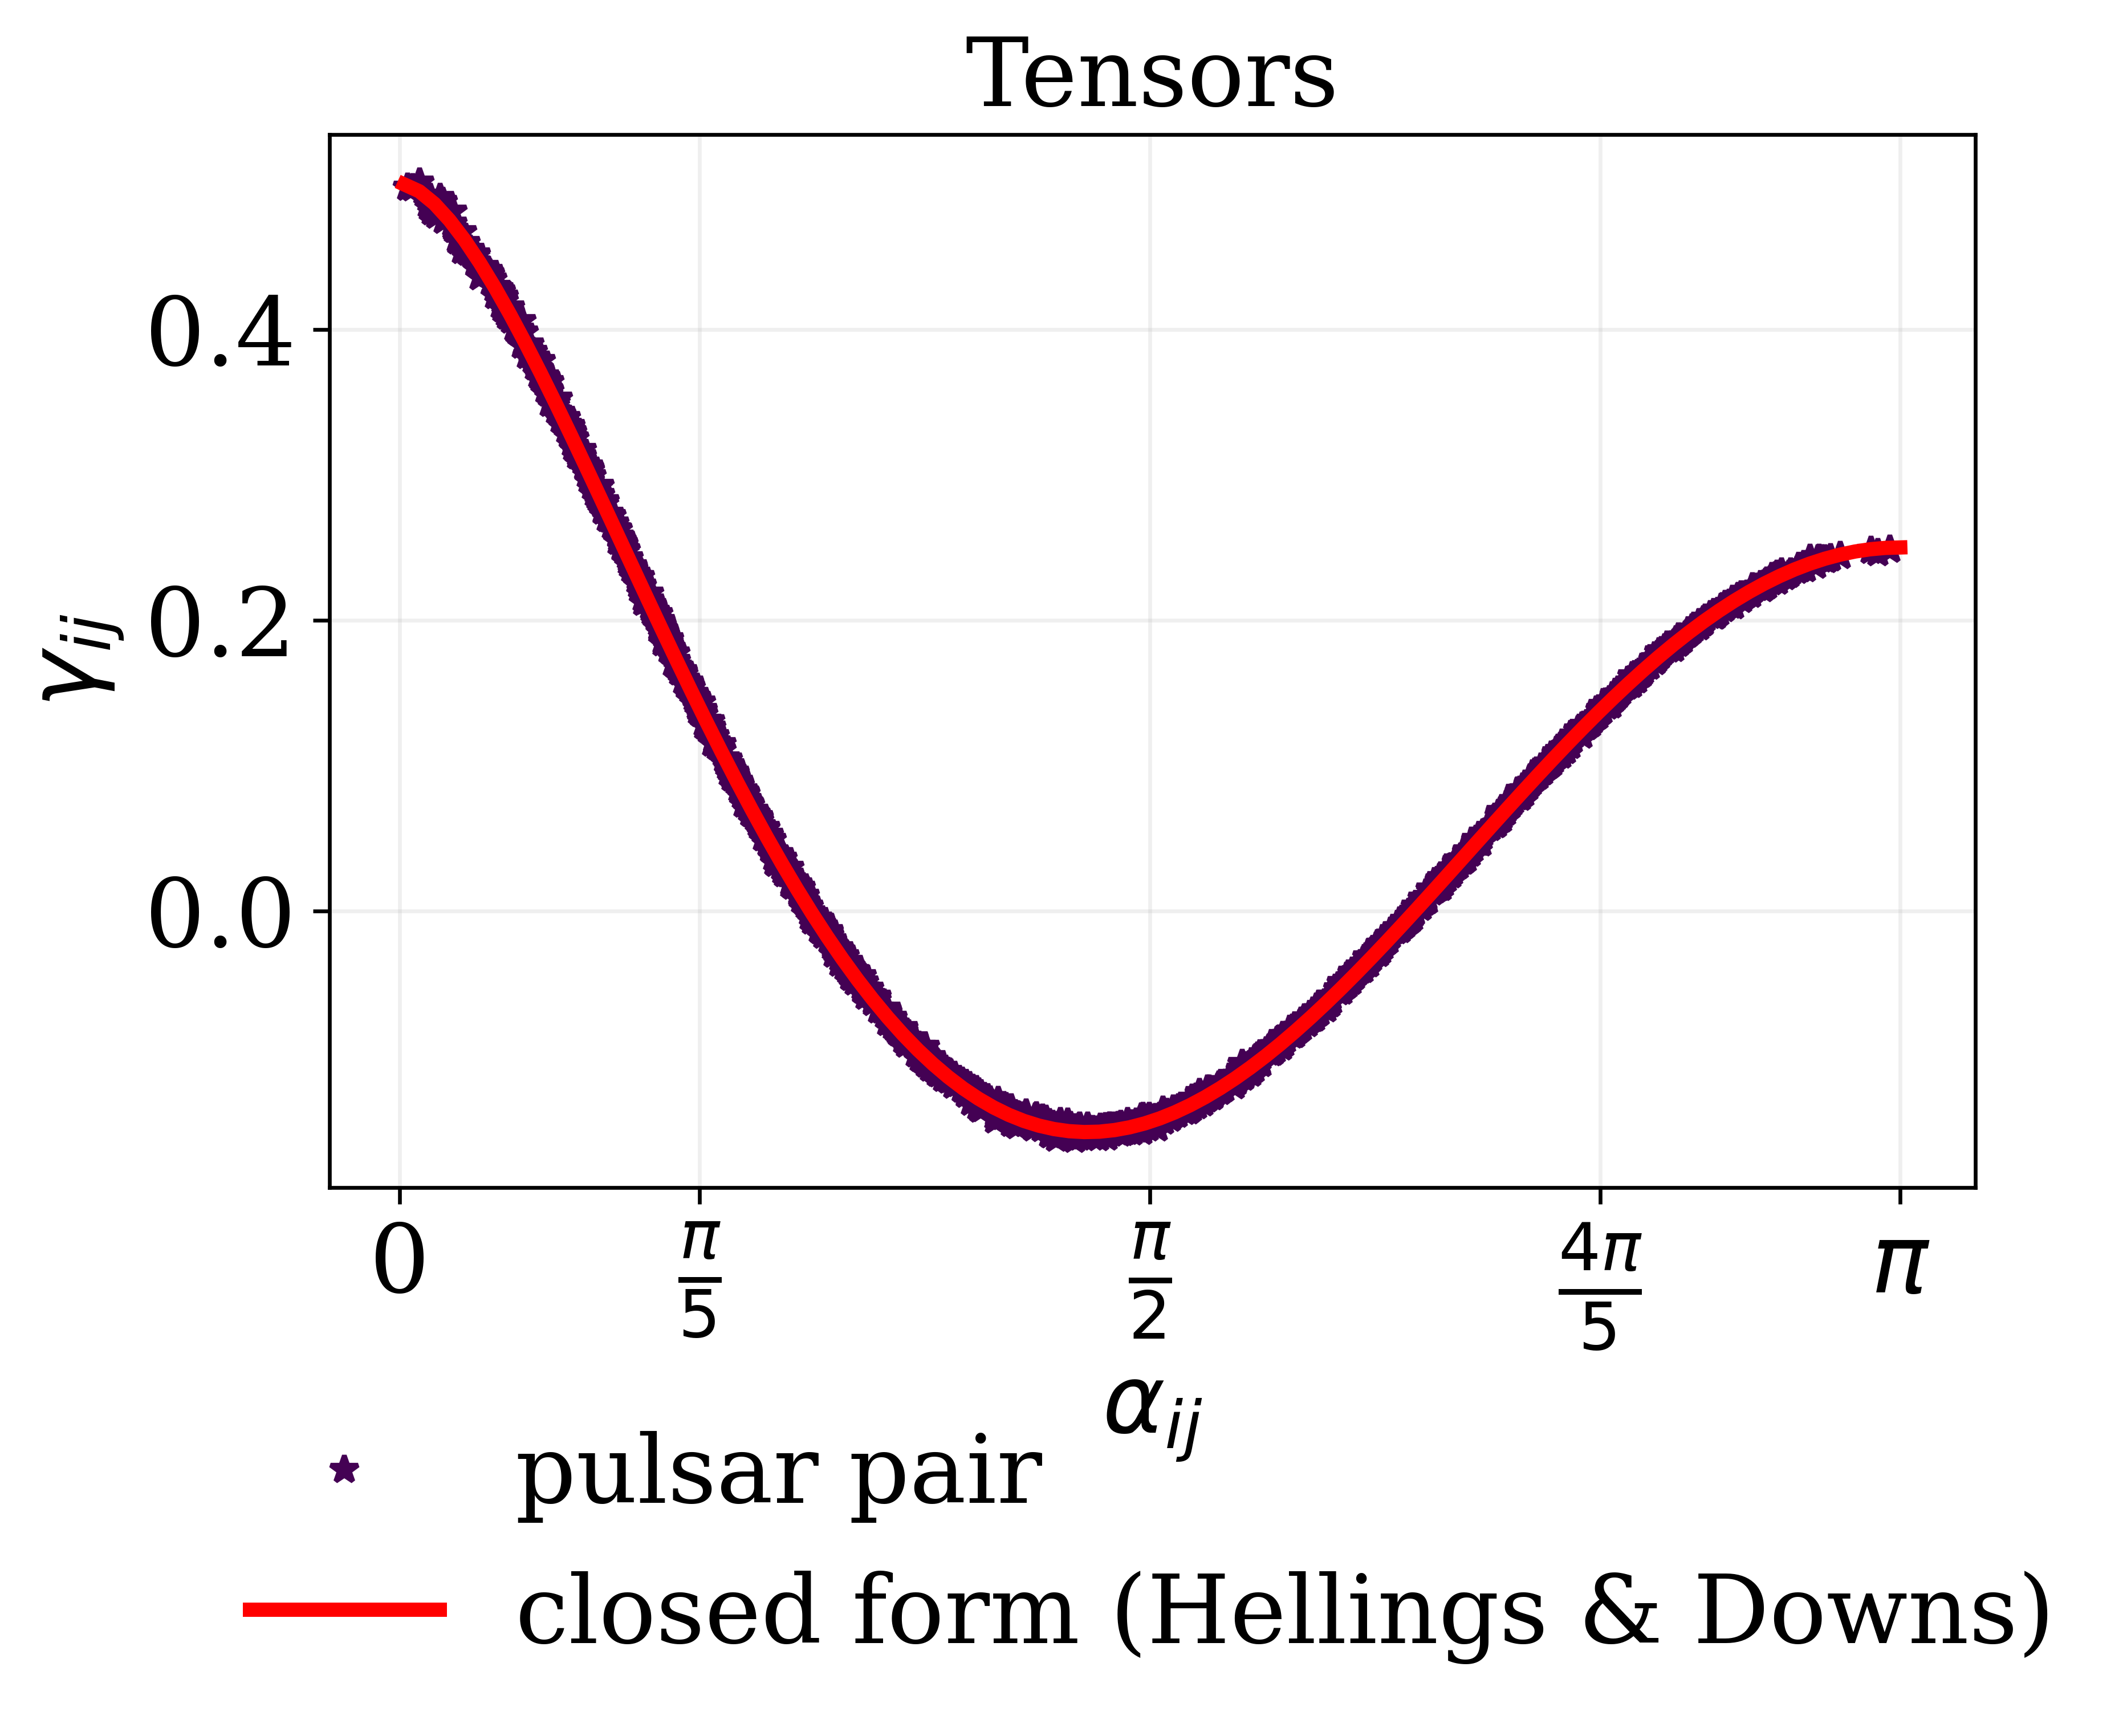

In [9]:
f = np.logspace(-9, -7, 100)
N, pulsar_xyz, d = detectors.get_NANOGrav_pulsars()

gamma_ij_t = []
alpha_ij = []
for i in range(N):
    for j in range(i+1, N):
        alpha_ij.append(np.arccos(np.dot(pulsar_xyz[i], pulsar_xyz[j])))
        gamma_ij_t.append(Response.overlap_pairwise(f, pulsar_xyz[i], pulsar_xyz[j], d[i], d[j], 't', 0))
        
gamma_ij_t = np.array(gamma_ij_t)
alpha_ij = np.array(alpha_ij)

f_index = np.argmin(np.abs(f - 1e-8))
gamma_ij_t_10_8 = gamma_ij_t[:,f_index]

def hellings_downs(alpha):
    return 0.5 + (3*(1- np.cos(alpha))/4 * (np.log(0.5*(1-np.cos(alpha)))- 1/6))

alpha = np.linspace(0.01, np.pi, 100)
hd = hellings_downs(alpha)

from matplotlib.ticker import MultipleLocator, FuncFormatter

def custom_pi_formatter(x, pos):
    if x == 0:
        return '0'
    elif x == np.pi / 5:
        return r'$\frac{\pi}{5}$'
    elif x == np.pi / 2:
        return r'$\frac{\pi}{2}$'
    elif x == 4 * np.pi / 5:
        return r'$\frac{4\pi}{5}$'
    elif x == np.pi:
        return r'$\pi$'
    else:
        return ''

custom_ticks = [0, np.pi / 5, np.pi / 2, 4 * np.pi / 5, np.pi]

fig, ax = plt.subplots()

ax.plot(alpha_ij, gamma_ij_t_10_8, '*', color=colors[0], label='pulsar pair')
ax.plot(alpha, hd, '-', color='red', label='closed form (Hellings & Downs)')
ax.set_xlabel(r'$\alpha_{ij}$')
ax.set_ylabel(r'$\gamma_{ij}$')
ax.grid(which='both', alpha=0.2)
ax.set_title('Tensors')
ax.set_xticks(custom_ticks)
ax.xaxis.set_major_formatter(FuncFormatter(custom_pi_formatter))


ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=1,  
    frameon=False
)


fig.tight_layout()
fig.subplots_adjust(bottom=0.25) 


## PLS
Power law integrated sensitivity curve


## Ground and Space based Detectors

```sens = pls.PLS(det1, det2, f, fref, pol, snr, Tobs, psi, shift_angle, fI=None, PnI=None, fJ=None, PnJ=None)```

Evaluate the sensitivity of a pair of detectors or a network of detectors to a Gravitational Wave Background (GWB) signal.

Parameters:
- det1, det2 : str or list of str
    The names of the detectors or the network of detectors to be considered.
    Supported options are:
    - Predefined detector or detector networks such as 'ET triangular', 'LISA', or custom detectors defined as lists with specific parameters.
    - For custom detectors, provide a list with the following elements: [c, xA, xB, l, name]
        - c: array_like of length 3 (position of the detector in the Earth-centered frame in meters)
        - xA: array_like of length 3 (unit vector pointing towards the detector in the Earth-centered frame)
        - xB: array_like of length 3 (unit vector pointing towards the detector in the Earth-centered frame)
        - l: float (length of the detector arm in meters)
        - name: str (name of the detector)

- f : array_like
    Frequency values (in Hz) for the Gravitational Wave signal.
- fref : float
    Reference frequency (in Hz) for the signal analysis.
- pol : str
    Polarization of the signal. Should be one of:
    - 't' for tensor polarization
    - 'v' for vector polarization
    - 's' for scalar polarization
    - 'I' for intensity
    - 'V' for circular polarization
- snr : float
    Signal-to-noise ratio (SNR) threshold for the analysis.
- Tobs : float
    Total observation time in years.
- psi : float
    
Optional parameters:

- shift_angle : float, optional
    Shift the angle of the response if considering ET 2L in radians
- fI, PnI, fJ, PnJ : optional
    Frequency arrays and corresponding Power Spectral Densities (PSDs) for custom detectors or custom PSD.
    These are used when no predefined detector networks are chosen.

Return:
- pls: array_like (power law sensitivity curve  ($h^2 \Omega_{GW}(f)$))
    The sensitivity of the detector(s) to the GWB signal, evaluated as the Power-Law Sensitivity (PLS). 
    This is a function of the observation time, SNR, and the detectors' noise characteristics.

Description:\
This function calculates the sensitivity of a pair of detectors or a network of detectors to a Gravitational Wave Background (GWB) signal, 
based on the given parameters. 
It evaluates the effective noise power spectral density and energy density for the signal and computes the corresponding sensitivity. 
The analysis can handle both predefined detector networks (such as LISA or ET) and custom detectors with user-supplied parameters.

- For custom detectors, the function interpolates the supplied PSDs with the frequencies given and calculates the overlap response between the detectors.
- The result is the sensitivity of the system to the GWB signal, given in terms of the Power-Law Sensitivity (PLS),
    which quantifies the detector network's ability to detect gravitational waves with the specified polarization, 
    frequency range, and observation time.

Note: for "ET triangular", it evaluates the sensitivity in the AET basis. This is particularly convenient if you want to consider correlated noise (under some assumptions). We do not specifically provide a function that takes that into account, but you can easily add your model of correlated noise by modifing 'psd_A', 'psd_E' and 'psd_T'. You can check an application of this by looking at this paper https://arxiv.org/pdf/2501.09057.


## Pulsar Timing Array


Compute the power law sensitivity curve for a pulsars catalog.

```pls_PTA = pls.PLS_PTA(f, snr, Tobs, pol, psi)```

Parameters:
- f: array (frequency array)
- snr: float (signal to noise ratio threshold)
- Tobs: float (observation time in years)
- pol: str (Polarization of the signal, 't' for tensor, 'v' for vector, 's' for scalar (only breathing), 'l' for longitudinal scalar, 'I' for tensor intensity stokes parameter, 'V' for tensor circular polarization stokes parameter )
- psi: float (Polarization angle in radians)

Return:
- pls: array_like (power law sensitivity curve  ($h^2 \Omega_{GW}(f)$)) 



2025-07-15 15:13:25.883 | DEBUG    | pint.models.binary_ddk:validate:211 - Validating DDK model in ECL coordinates


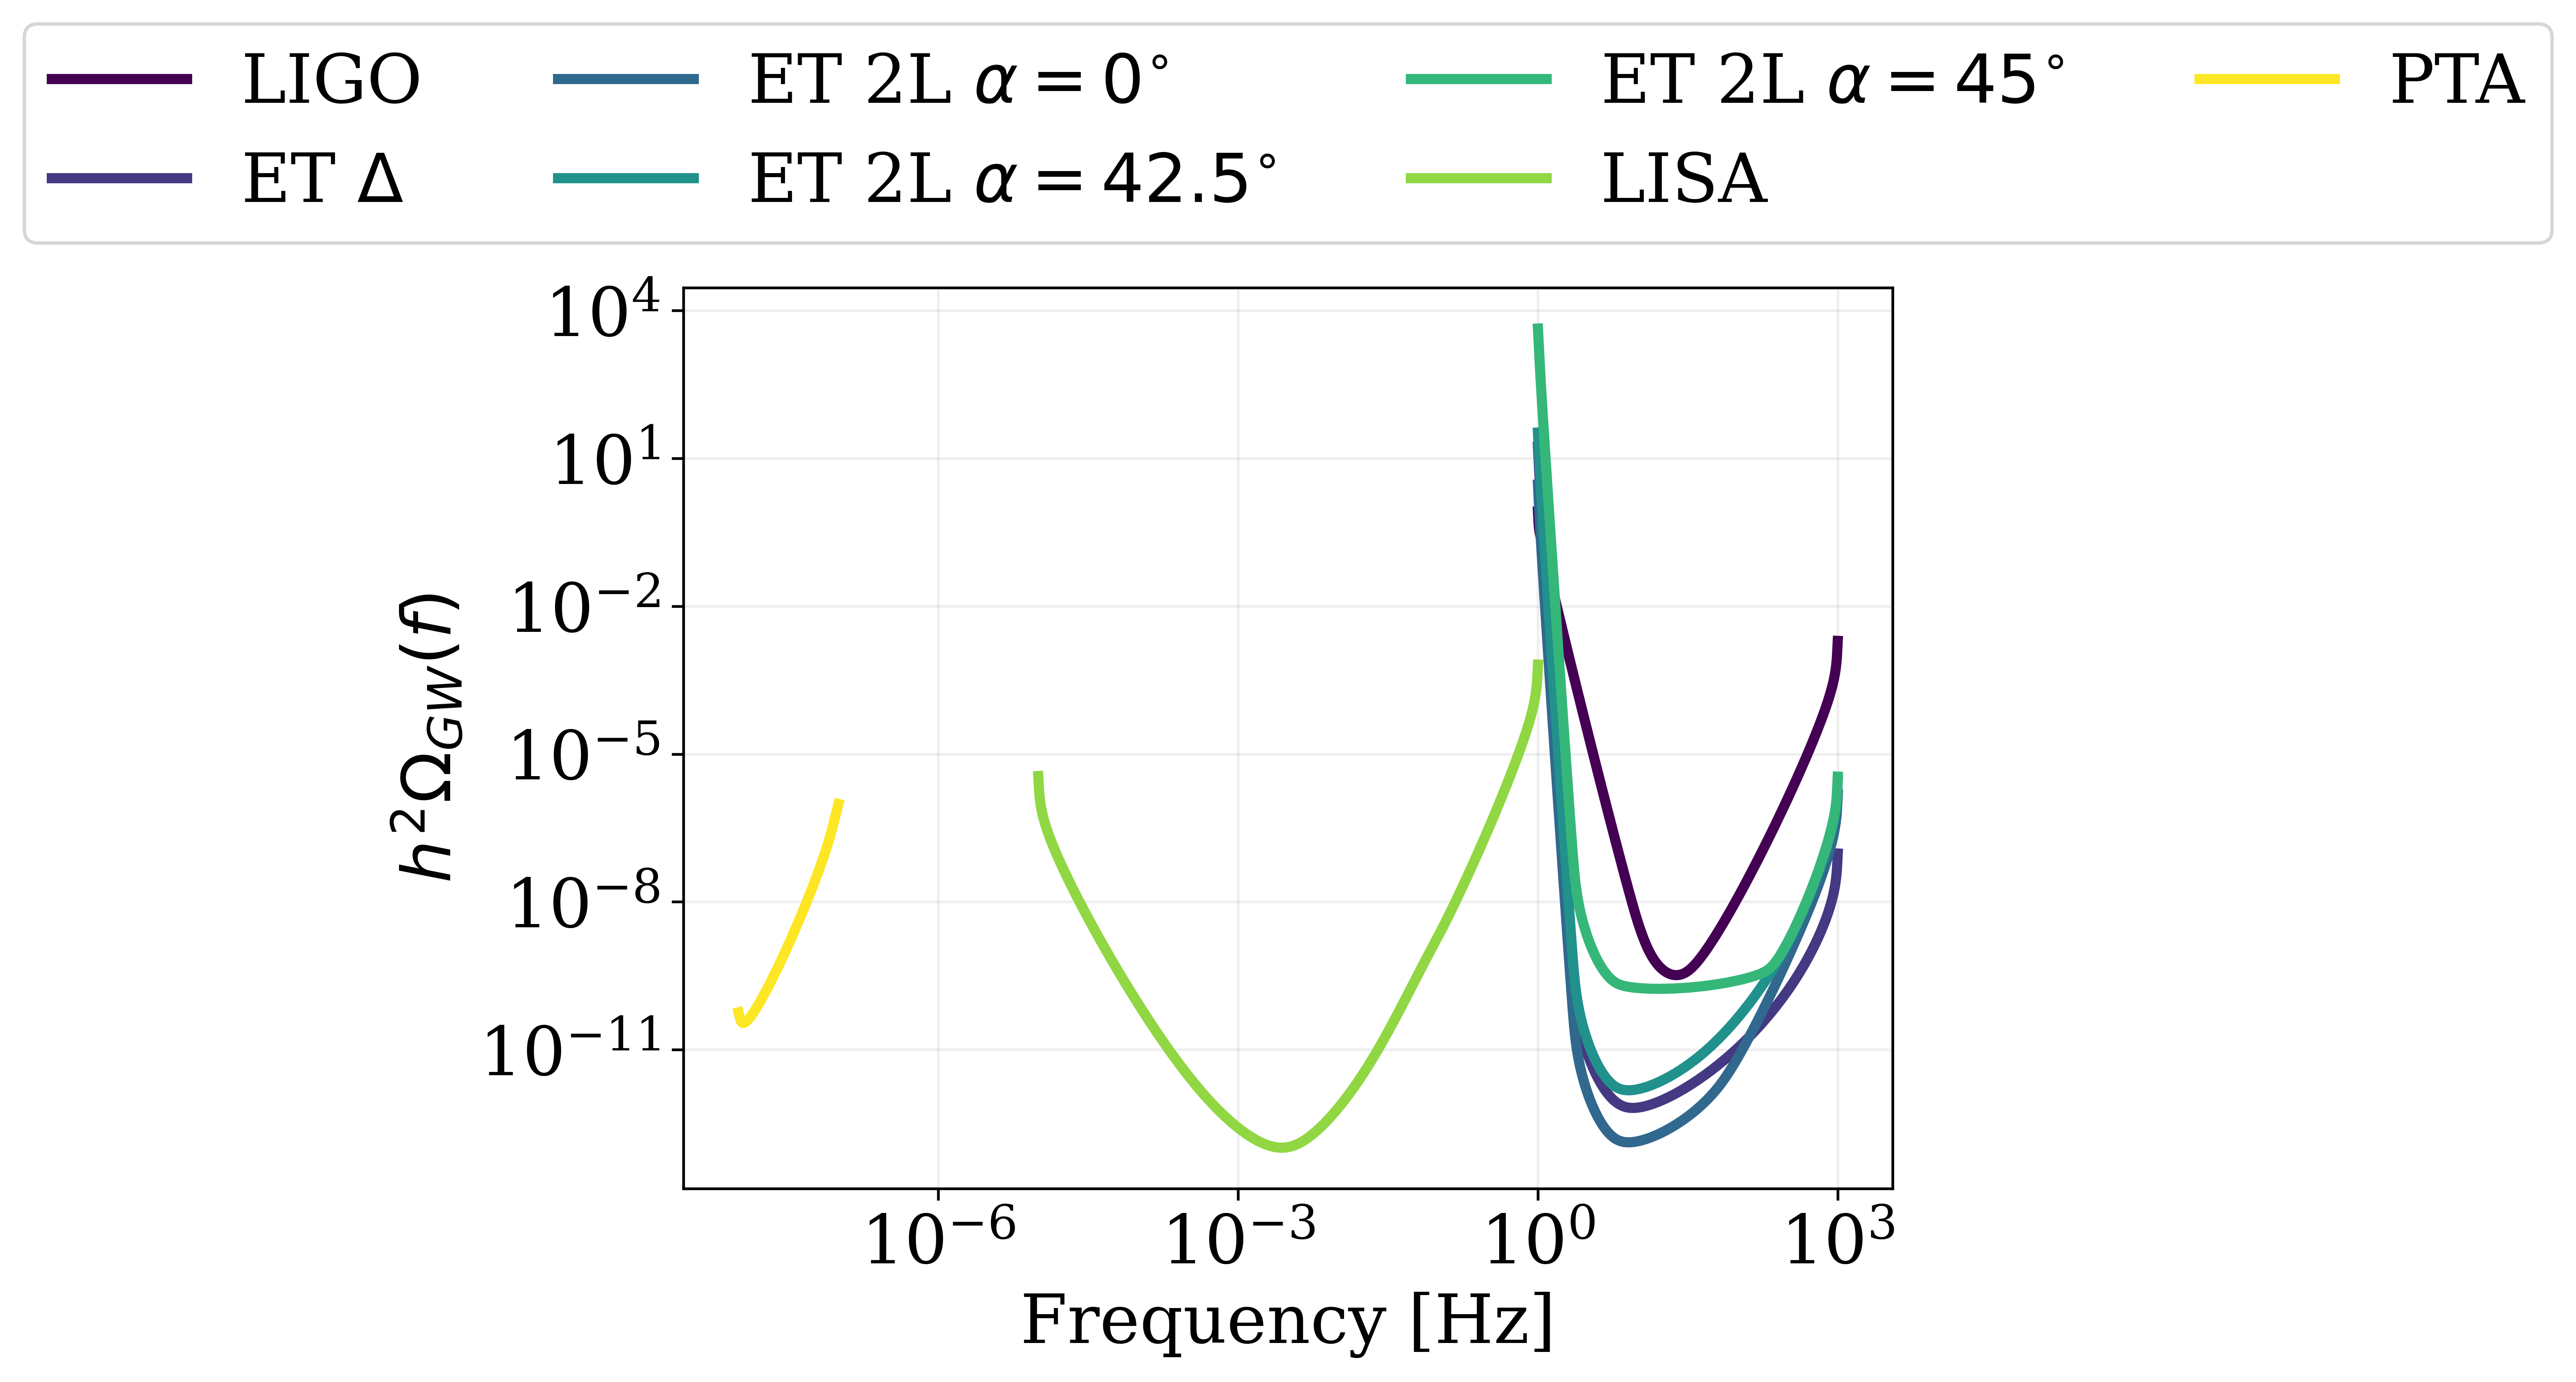

In [10]:
f = np.logspace(0, 3, 1000)
f_LISA = np.logspace(-5, 0, 1000)
f_PTA = np.logspace(-8, -7, 100)

fref = 25
fref_LISA = 1e-2
snr_ = 1
snr_LISA = 10
Tobs = 1
Tobs_LISA = 3
psi = 0
Tobs_PTA = 15

pls_LIGO = pls.PLS('LIGO H', 'LIGO L', f, fref, 't', snr_, Tobs, psi)
pls_ET = pls.PLS('ET X', 'ET Y', f, fref, 't', snr_, Tobs, psi)
pls_ET2L0 = pls.PLS('ET L1', 'ET L2', f, fref, 't', snr_, Tobs, psi, 0)
pls_ET2L425 = pls.PLS('ET L1', 'ET L2', f, fref, 't', snr_, Tobs, psi, np.deg2rad(42.5))
pls_ET2L45 = pls.PLS('ET L1', 'ET L2', f, fref, 't', snr_, Tobs, psi, np.pi/4)
pls_LISA = pls.PLS('LISA', 'Network', f_LISA, fref_LISA, 't', snr_LISA, Tobs_LISA, psi)
pls_PTA = pls.PLS_PTA(f_PTA, snr_, Tobs_PTA, 't', psi)

cmap = cm.get_cmap('viridis', 7)
colors = [cmap(i) for i in range(cmap.N)]

plt.plot(f, pls_LIGO, label='LIGO', color=colors[0])
plt.plot(f, pls_ET, label=r'ET $\Delta$', color=colors[1])
plt.plot(f, pls_ET2L0, label=r'ET 2L $\alpha=0^{\circ}$', color=colors[2])
plt.plot(f, pls_ET2L425, label=r'ET 2L $\alpha=42.5^{\circ}$', color=colors[3])
plt.plot(f, pls_ET2L45, label=r'ET 2L $\alpha=45^{\circ}$', color=colors[4])
plt.plot(f_LISA, pls_LISA, label='LISA', color=colors[5])
plt.plot(f_PTA, pls_PTA, label='PTA', color=colors[6])
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$h^2 \Omega_{GW}(f)$')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.33), ncol=4)
plt.grid(which='both', alpha=0.2)
plt.show()

# SNR evaluation

```snr_detectors = SNR(Tobs, f, gw_params, detectors_list, pol, psi, shift_angle=None, gw_spectrum_func=None)```

Compute the signal-to-noise ratio (SNR) for a given gravitational wave (GW) signal using multiple detector pairs.
Supports either a parameterized GW spectrum or a custom function.

Parameters
- Tobs : float (Observation time in years)
- f : array_like (Frequency of the GW signal)
- gw_params : array-like or None (if array-like, it should be [logA_gw, n_gw, fref], if None you have to consider a gw_spectrum_func later)
- detectors_list : list of str (list of detector names)
- pol : str (polarization of the GW signal)
- psi : float,  (polarization angle of the GW signal (default is 0))
- shift_angle : float, optional (shift angle used if one of the detectors is ET_L2)
- gw_spectrum_func : function, optional (Custom function defining the GW energy spectrum Omega_GW(f))

Return
- snr: float (computed signal-to-noise ratio (SNR))

In [11]:
# snr LIGO 
Tobs = 1
f = np.logspace(0, 3, 1000)
log10A_gw = np.log10(pls_LIGO.min()/h**2)
fref=25
n_gw = 0
gw_params=[log10A_gw, n_gw, fref]

#test with a custom function for the GW spectrum

def Omega_GW(f):
    log10A_gw, n_gw, fref = gw_params
    return 10**log10A_gw * (f / fref) ** n_gw

det_list = ['LIGO H', 'LIGO L']
snr_LIGO = snr.SNR(Tobs, f, None, det_list, 't', psi=0, shift_angle=None, gw_spectrum_func=Omega_GW)
print(snr_LIGO)

0.9998909351913536


In [12]:
# snr ET
Tobs = 1
f = np.logspace(0, 3, 1000)
logA_gw = np.log10(pls_ET.min()/h**2)
fref=25
n_gw = 0
det_list = ['ET X', 'ET Y']
gw_params=[logA_gw, n_gw, fref]
snr_ET = snr.SNR(Tobs, f, gw_params, det_list, 't', psi=0)
print(snr_ET)

0.9997937956175468


In [13]:
# snr ET 2L alpha=0
Tobs = 1
f = np.logspace(0, 3, 1000)
logA_gw = np.log10(pls_ET2L0.min()/h**2)
fref=25
n_gw = 0
det_list = ['ET L1', 'ET L2']
gw_params=[logA_gw, n_gw, fref]
snr_ET2L0 = snr.SNR(Tobs, f, gw_params, det_list, 't', psi=0, shift_angle=0)
print(snr_ET2L0)

# snr ET 2L alpha=45
Tobs = 1
f = np.logspace(0, 3, 1000)
logA_gw = np.log10(pls_ET2L45.min()/h**2)
fref=25
n_gw = 0
det_list = ['ET L1', 'ET L2']
gw_params=[logA_gw, n_gw, fref]
snr_ET2L45 = snr.SNR(Tobs, f, gw_params, det_list, 't', psi=0, shift_angle=np.pi/4)
print(snr_ET2L45)

0.9997334262250638
0.9971999040368131


In [14]:
# snr LISA
Tobs = 3
f = np.logspace(-5, 0, 1000)
logA_gw = np.log10(pls_LISA.min()/h**2)
fref=1e-2
n_gw = 0
gw_params=[logA_gw, n_gw, fref]
snr_LISA = snr.SNR(Tobs, f, gw_params, ['LISA'], 't', psi=0, shift_angle=None)
print(snr_LISA)

9.998097290573172


In [15]:
# snr PTA
Tobs_PTA = 15
f_PTA = np.logspace(-8, -7, 100)
gw_params = [np.log10(pls_PTA.min()/h**2), 0, 1e-8]
snr_NANOGrav = snr.SNR(Tobs_PTA, f_PTA, gw_params, ['pulsars'], 't', psi=0)
print(snr_NANOGrav)

2025-07-15 15:18:30.285 | DEBUG    | pint.models.binary_ddk:validate:211 - Validating DDK model in ECL coordinates


1.0006576616068434


# Angular Response

## Ground and Space Based Detectors

Calculate the angular response of a detector to a GWB signal for a specific multipole ell.

```Rell = AngularResponse.R_ell( ell, det1, det2, f, pol, psi, shift_angle=False)```

Parameters:
- ell: int positive (Multipole to consider)
- det1, det2: str or list of str
    The name of the detector(s) to consider.
    The names must be in the list of detectors available in the response module.
    The list of available detectors can be obtained by calling the function ```detectors.available_detectors()```.
    The names of the detectors are case sensitive.
    If you want to provide a custom detector, you can provide the following information in a list:

   ``` H = [c, xA, xB, l, name]```

    - c: array_like of length 3 (Position of the detector in the Earth-centered frame in meters)
    - xA: array_like of length 3 (Unit vector pointing towards the detector in the Earth-centered frame)
    - xB: array_like of length 3 (Unit vector pointing towards the detector in the Earth-centered frame)
    - l: float (Length of the arm in meters)
    - name: str (Name of the detector)

- f: array_like (Frequency in Hz)
- pol: str (Polarization of the signal, 't' for tensor, 'v' for vector, 's' for scalar, 'I' for intensity and 'V' for circular polarization)
- psi: float (Polarization angle in radians)

Optional parameters:

- shift_angle: bool or float (Shift the angle of the response if considering ET 2L in radians)

Return:
- Rell: array_like (Angular response function)




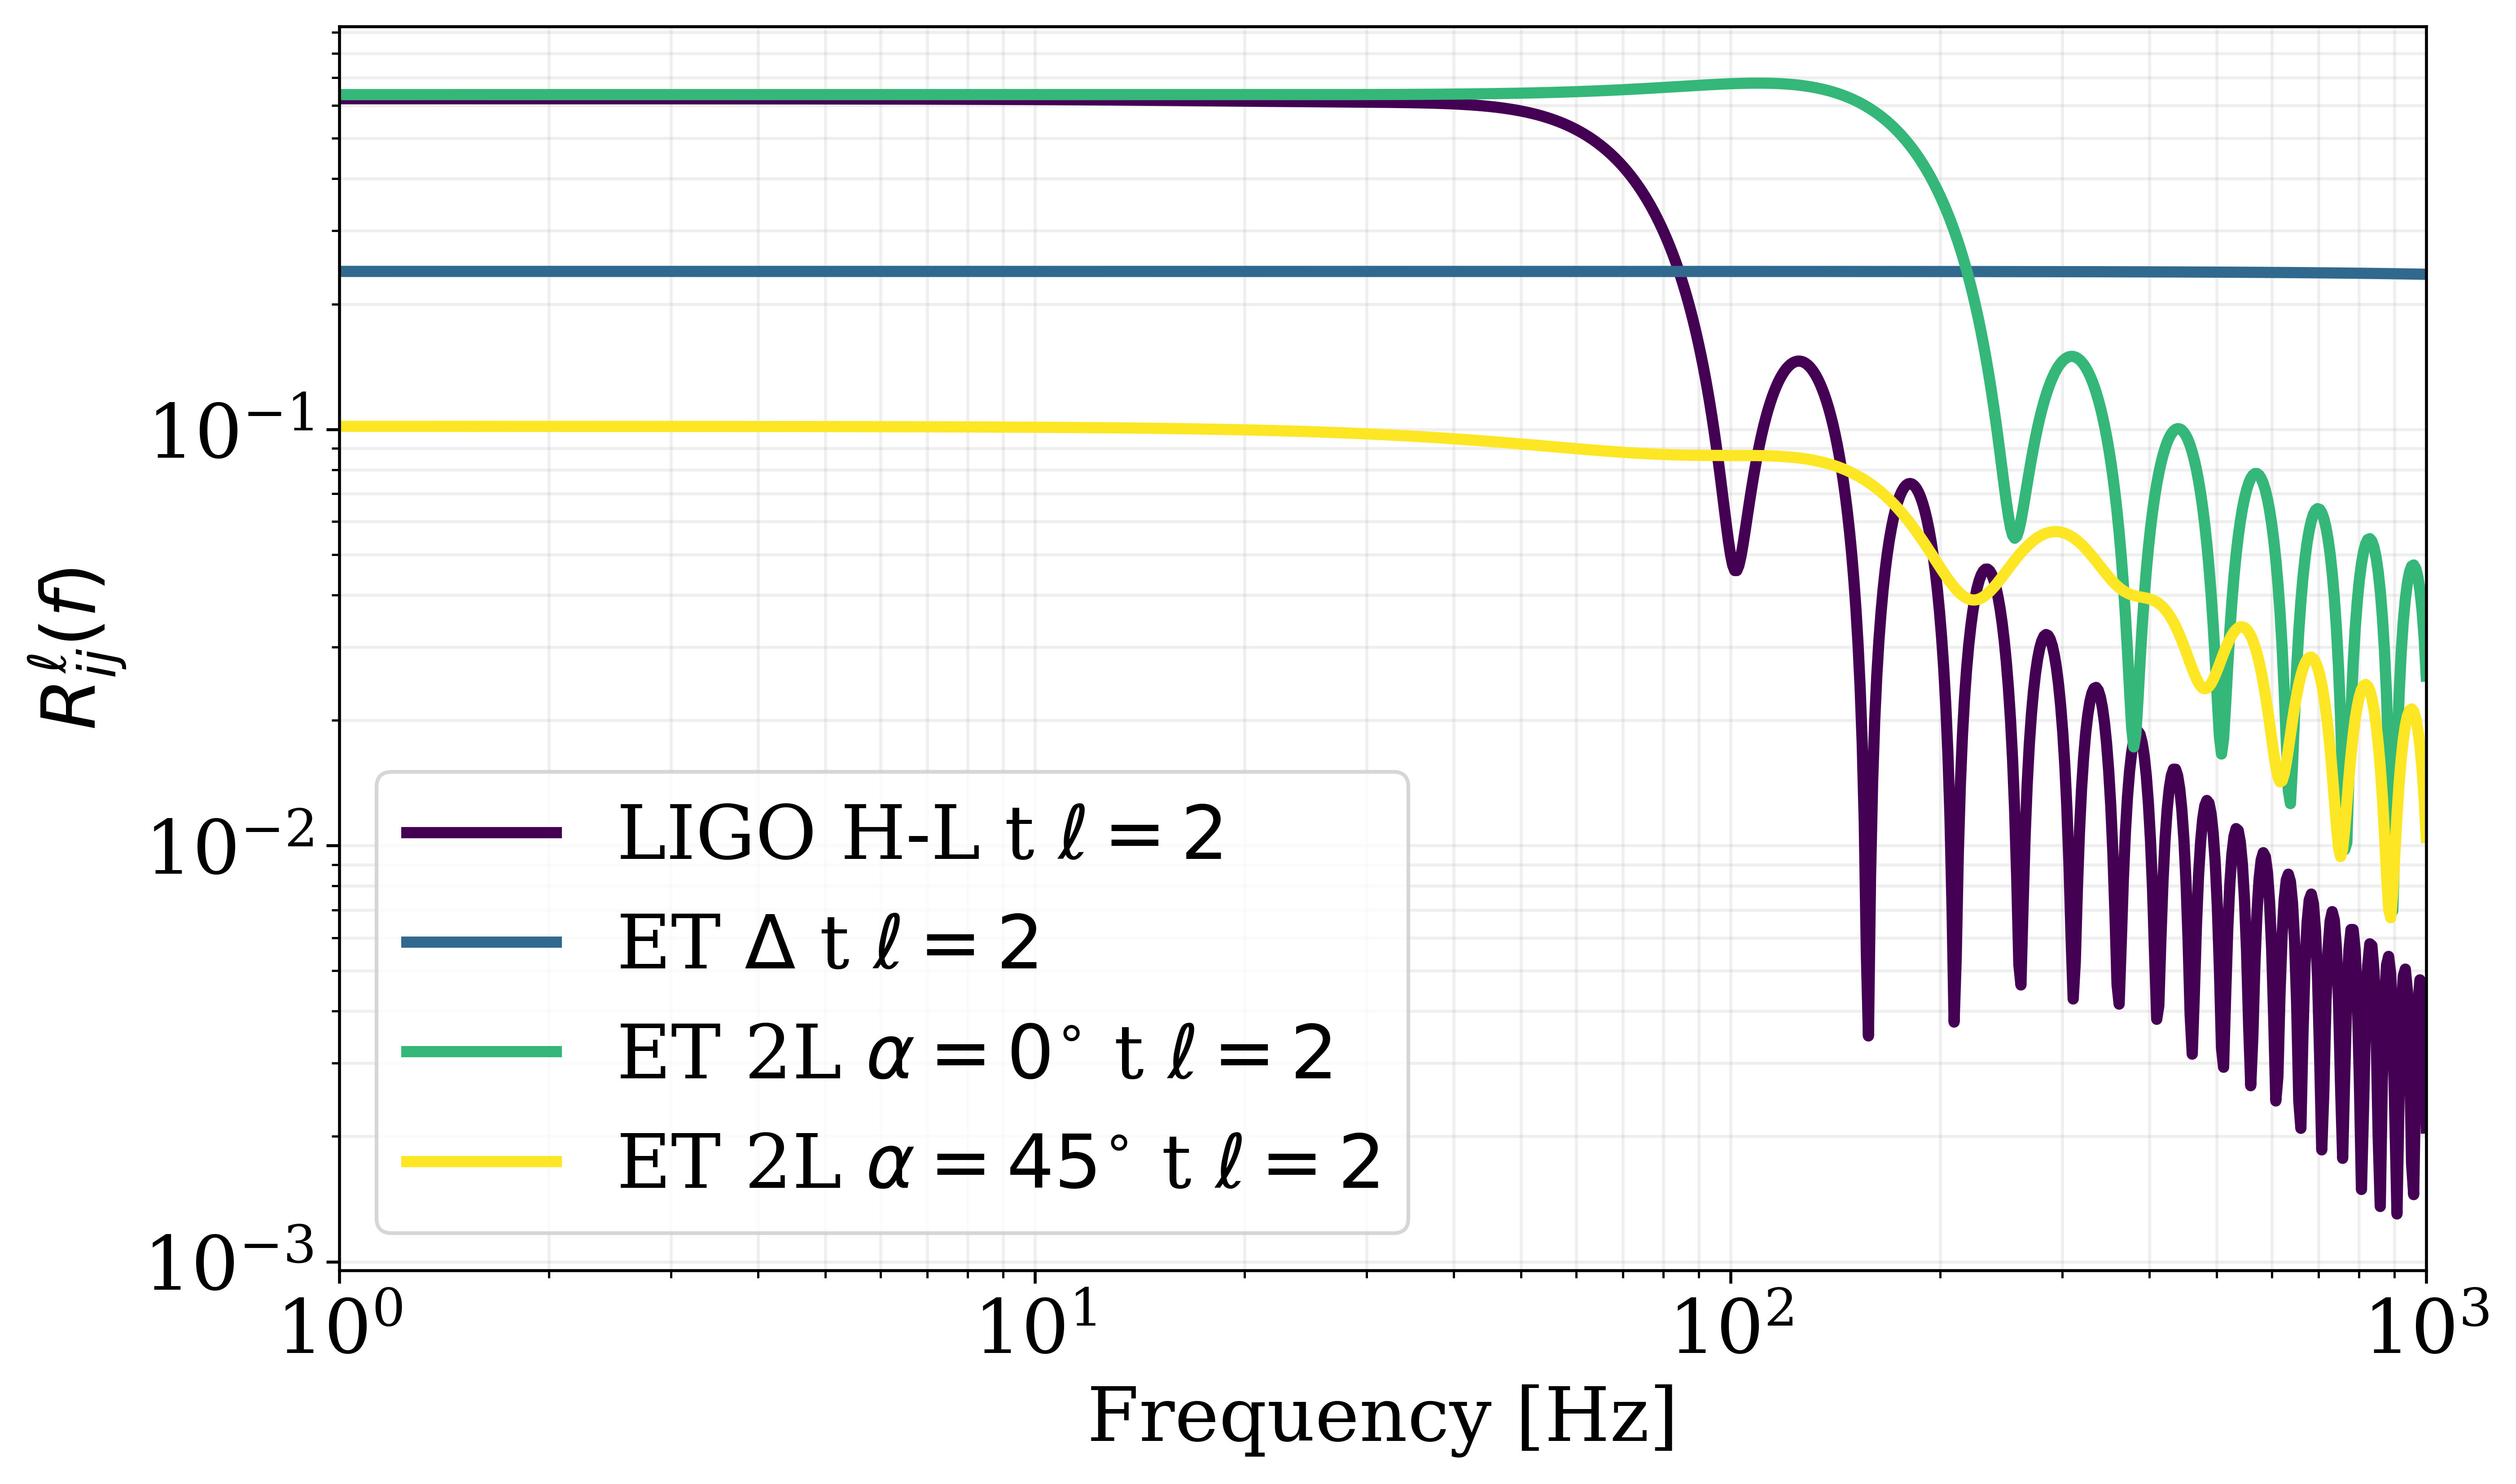

In [16]:
ell = 2
f = np.logspace(0, 3, 1000)
R2_LIGO = AngularResponse.R_ell(ell, 'LIGO H', 'LIGO L', f, 't', 0)
R2_ET = AngularResponse.R_ell(ell, 'ET X', 'ET Y', f, 't', 0)
R2_ET2L0 = AngularResponse.R_ell(ell, 'ET L1', 'ET L2', f, 't', 0, shift_angle=0)
R2_ET2L45 = AngularResponse.R_ell(ell, 'ET L1', 'ET L2', f, 't', 0, shift_angle=np.pi/4)

cmap = matplotlib.colormaps['viridis']
colors = cmap(np.linspace(0, 1, 4))

plt.figure(figsize=(10, 6))
plt.plot(f, R2_LIGO, label=r'LIGO H-L t $\ell=2$', color=colors[0])
plt.plot(f, R2_ET, label=r'ET $\Delta$ t $\ell=2$', color=colors[1])
plt.plot(f, R2_ET2L0, label=r'ET 2L $\alpha=0^{\circ}$ t $\ell=2$', color=colors[2])
plt.plot(f, R2_ET2L45, label=r'ET 2L $\alpha=45^{\circ}$ t $\ell=2$', color=colors[3])

plt.xlabel('Frequency [Hz]')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$R_{ij}^{\ell}(f)$')
plt.xlim(f.min(), f.max())
plt.grid(which='both', alpha=0.2)
plt.legend()  
plt.show()

## LISA AET basis

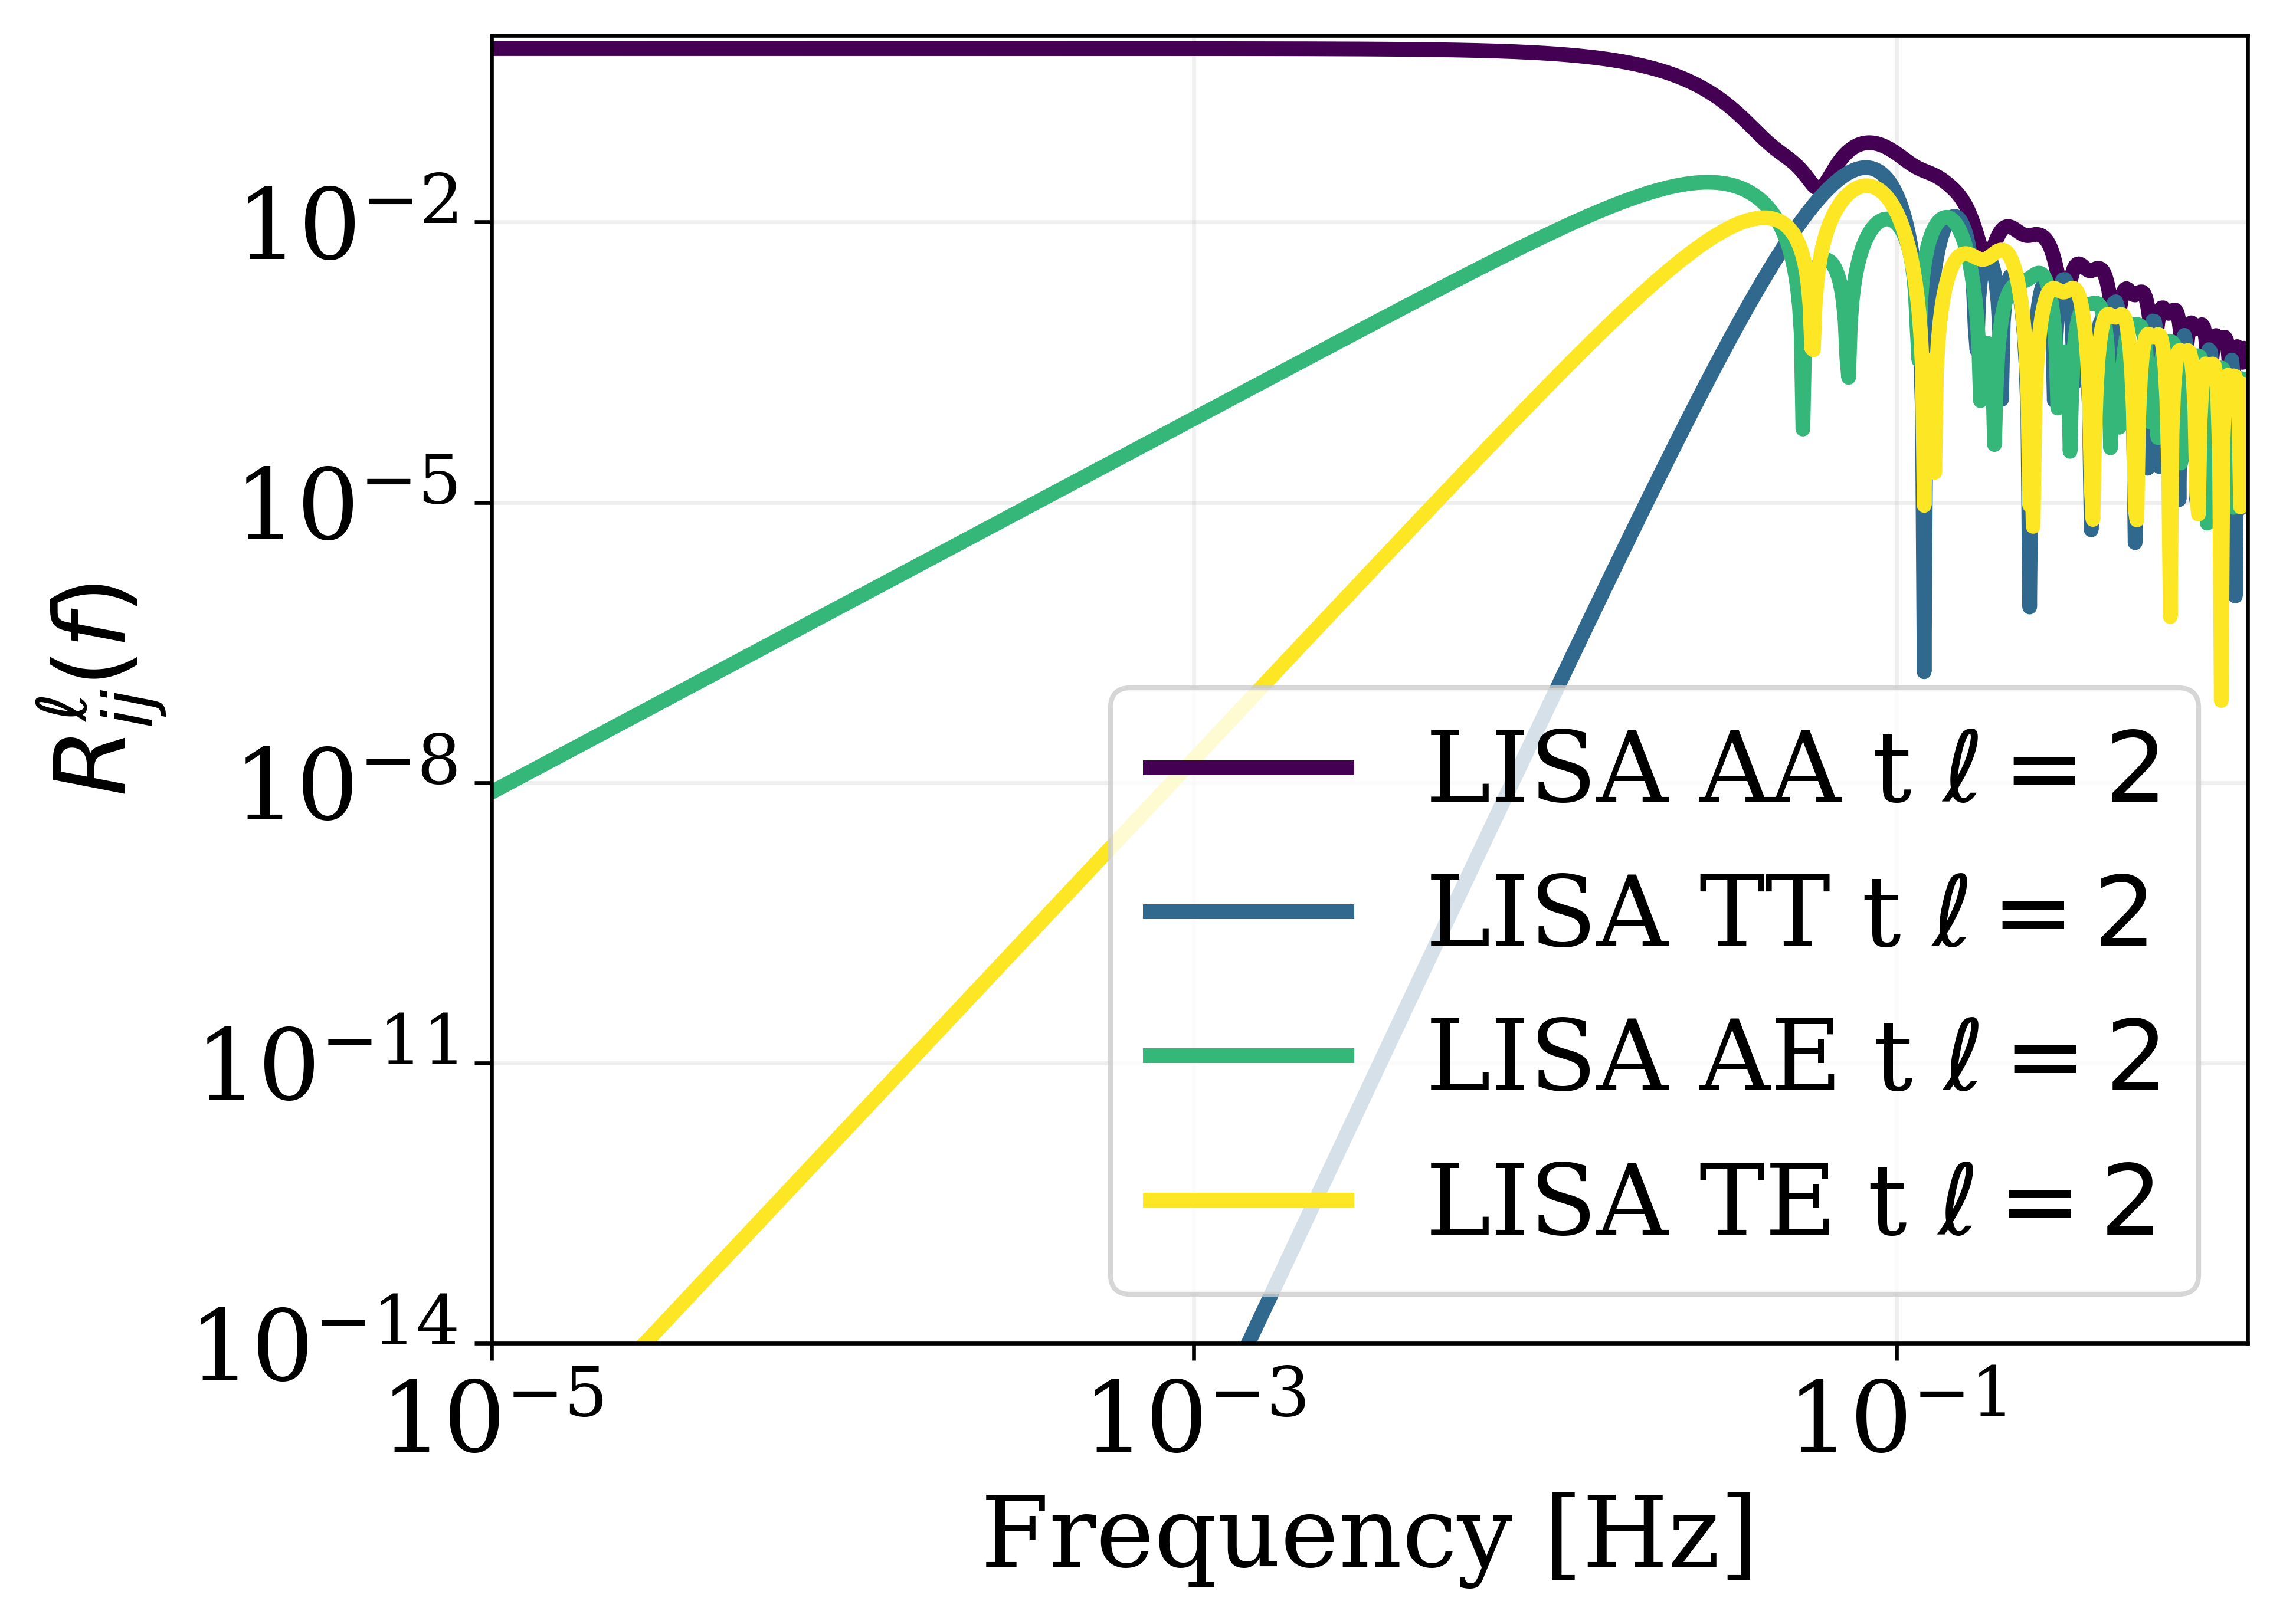

In [17]:
ell = 2
f_lisa = np.logspace(-5, 0, 1000)
R2_LISA_AA = AngularResponse.R_ell(ell,'LISA A', 'LISA A', f_lisa, 't', 0)
R2_LISA_TT = AngularResponse.R_ell(ell,'LISA T', 'LISA T', f_lisa, 't', 0)
R2_LISA_AE = AngularResponse.R_ell(ell,'LISA A', 'LISA E', f_lisa, 't', 0)
R2_LISA_TE = AngularResponse.R_ell(ell,'LISA E', 'LISA T', f_lisa, 't', 0)

cmap = matplotlib.colormaps['viridis']
colors = cmap(np.linspace(0, 1, 4))

plt.figure()
plt.plot(f_lisa, R2_LISA_AA, label='LISA AA t $\ell=2$', color=colors[0])
plt.plot(f_lisa, R2_LISA_TT, label='LISA TT t $\ell=2$', color=colors[1])
plt.plot(f_lisa, R2_LISA_AE, label='LISA AE t $\ell=2$', color=colors[2])
plt.plot(f_lisa, R2_LISA_TE, label='LISA TE t $\ell=2$', color=colors[3])
plt.xlabel('Frequency [Hz]')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$R_{ij}^{\ell}(f)$')
plt.xlim(f_lisa.min(), f_lisa.max())
plt.grid(which='both', alpha=0.2)
plt.ylim(1e-14, 1)
plt.legend()

# Pulsar Timing Array

Compute the angular response for a pair of pulsars

```gamma2_ij_t[i]=AngularResponse.R_ell_pairwise(ell, f, pulsar_xyz[i], pulsar_xyz[j],  d[i], d[j], 't', psi)```

Parameters:
- ell: int (multipole to consider)
- pi: len(3) array_like (pulsar i position in the xyz coordinates)
- pj: len(3) array_like (pulsar j position in the xyz coordinates)
- f: array_like (frequency in Hz)
- pol: str (polarization: 't' for tensor, 'v' for vector, 's' for scalar, 'I' for intensity, 'V' for circular polarization)
- psi: float (Polarization angle in radians (default is 0))

Returns:
- angular_response: array_like (angular response for a pair of pulsar)
       

In [18]:
gamma2_ij_t = []
alpha_ij = []
ell=2
psi = 0
for i in range(N):
    for j in range(i+1, N):
        alpha_ij.append(np.arccos(np.dot(pulsar_xyz[i], pulsar_xyz[j])))
        gamma2_ij_t.append(AngularResponse.R_ell_pairwise(ell, f, pulsar_xyz[i], pulsar_xyz[j],  d[i], d[j], 't', psi))

gamma2_ij_t = np.array(gamma2_ij_t)
alpha_ij = np.array(alpha_ij)



In [19]:
f_index = np.argmin(np.abs(f - 1e-8))
gamma2_ij_t_10_8 = gamma2_ij_t[:,f_index]

In [20]:
# check with the literature https://arxiv.org/pdf/1306.5394

def R_22(alpha):
    term1 = -0.25 * np.sqrt(5*np.pi/6) * (1-np.cos(alpha))/(1+ np.cos(alpha))
    term2 = (1+ np.cos(alpha)) *((np.cos(alpha))**2 + 4* np.cos(alpha)-9)
    term3 = -24 * (1-np.cos(alpha)) * np.log(np.sin(alpha/2))
    return term1 * (term2 + term3)  

def R_21(alpha):
    term1 = 0.25*np.sqrt(2*np.pi/15)*np.sin(alpha)
    term2 = 5*(np.cos(alpha)**2) + 15*np.cos(alpha) -21
    term3 = -60*(1-np.cos(alpha))/(1+np.cos(alpha))*np.log(np.sin(alpha/2))
    return term1 * (term2 + term3)

def R_20(alpha):
    term1 = np.sqrt(np.pi/5)/3
    term2 = np.cos(alpha) 
    term3 = 15*(1-np.cos(alpha))/4
    term4 = (1+np.cos(alpha))*(np.cos(alpha)+3) + 8*np.log(np.sin(alpha/2))
    return term1*(term2 + term3*term4)

def R_2_2(alpha):
    return - R_22(alpha)

def R_2_1(alpha):
    return - R_21(alpha)

def R_2(alpha):
    term1 = R_2_2(alpha)
    term2 = R_2_1(alpha)
    term3 = R_20(alpha)
    term4 = R_21(alpha)
    term5 = R_22(alpha)
    return np.sqrt(term1**2 + term2**2 + term3**2 + term4**2 + term5**2)

alpha = np.linspace(1e-3, np.pi- 1e-3, 100)

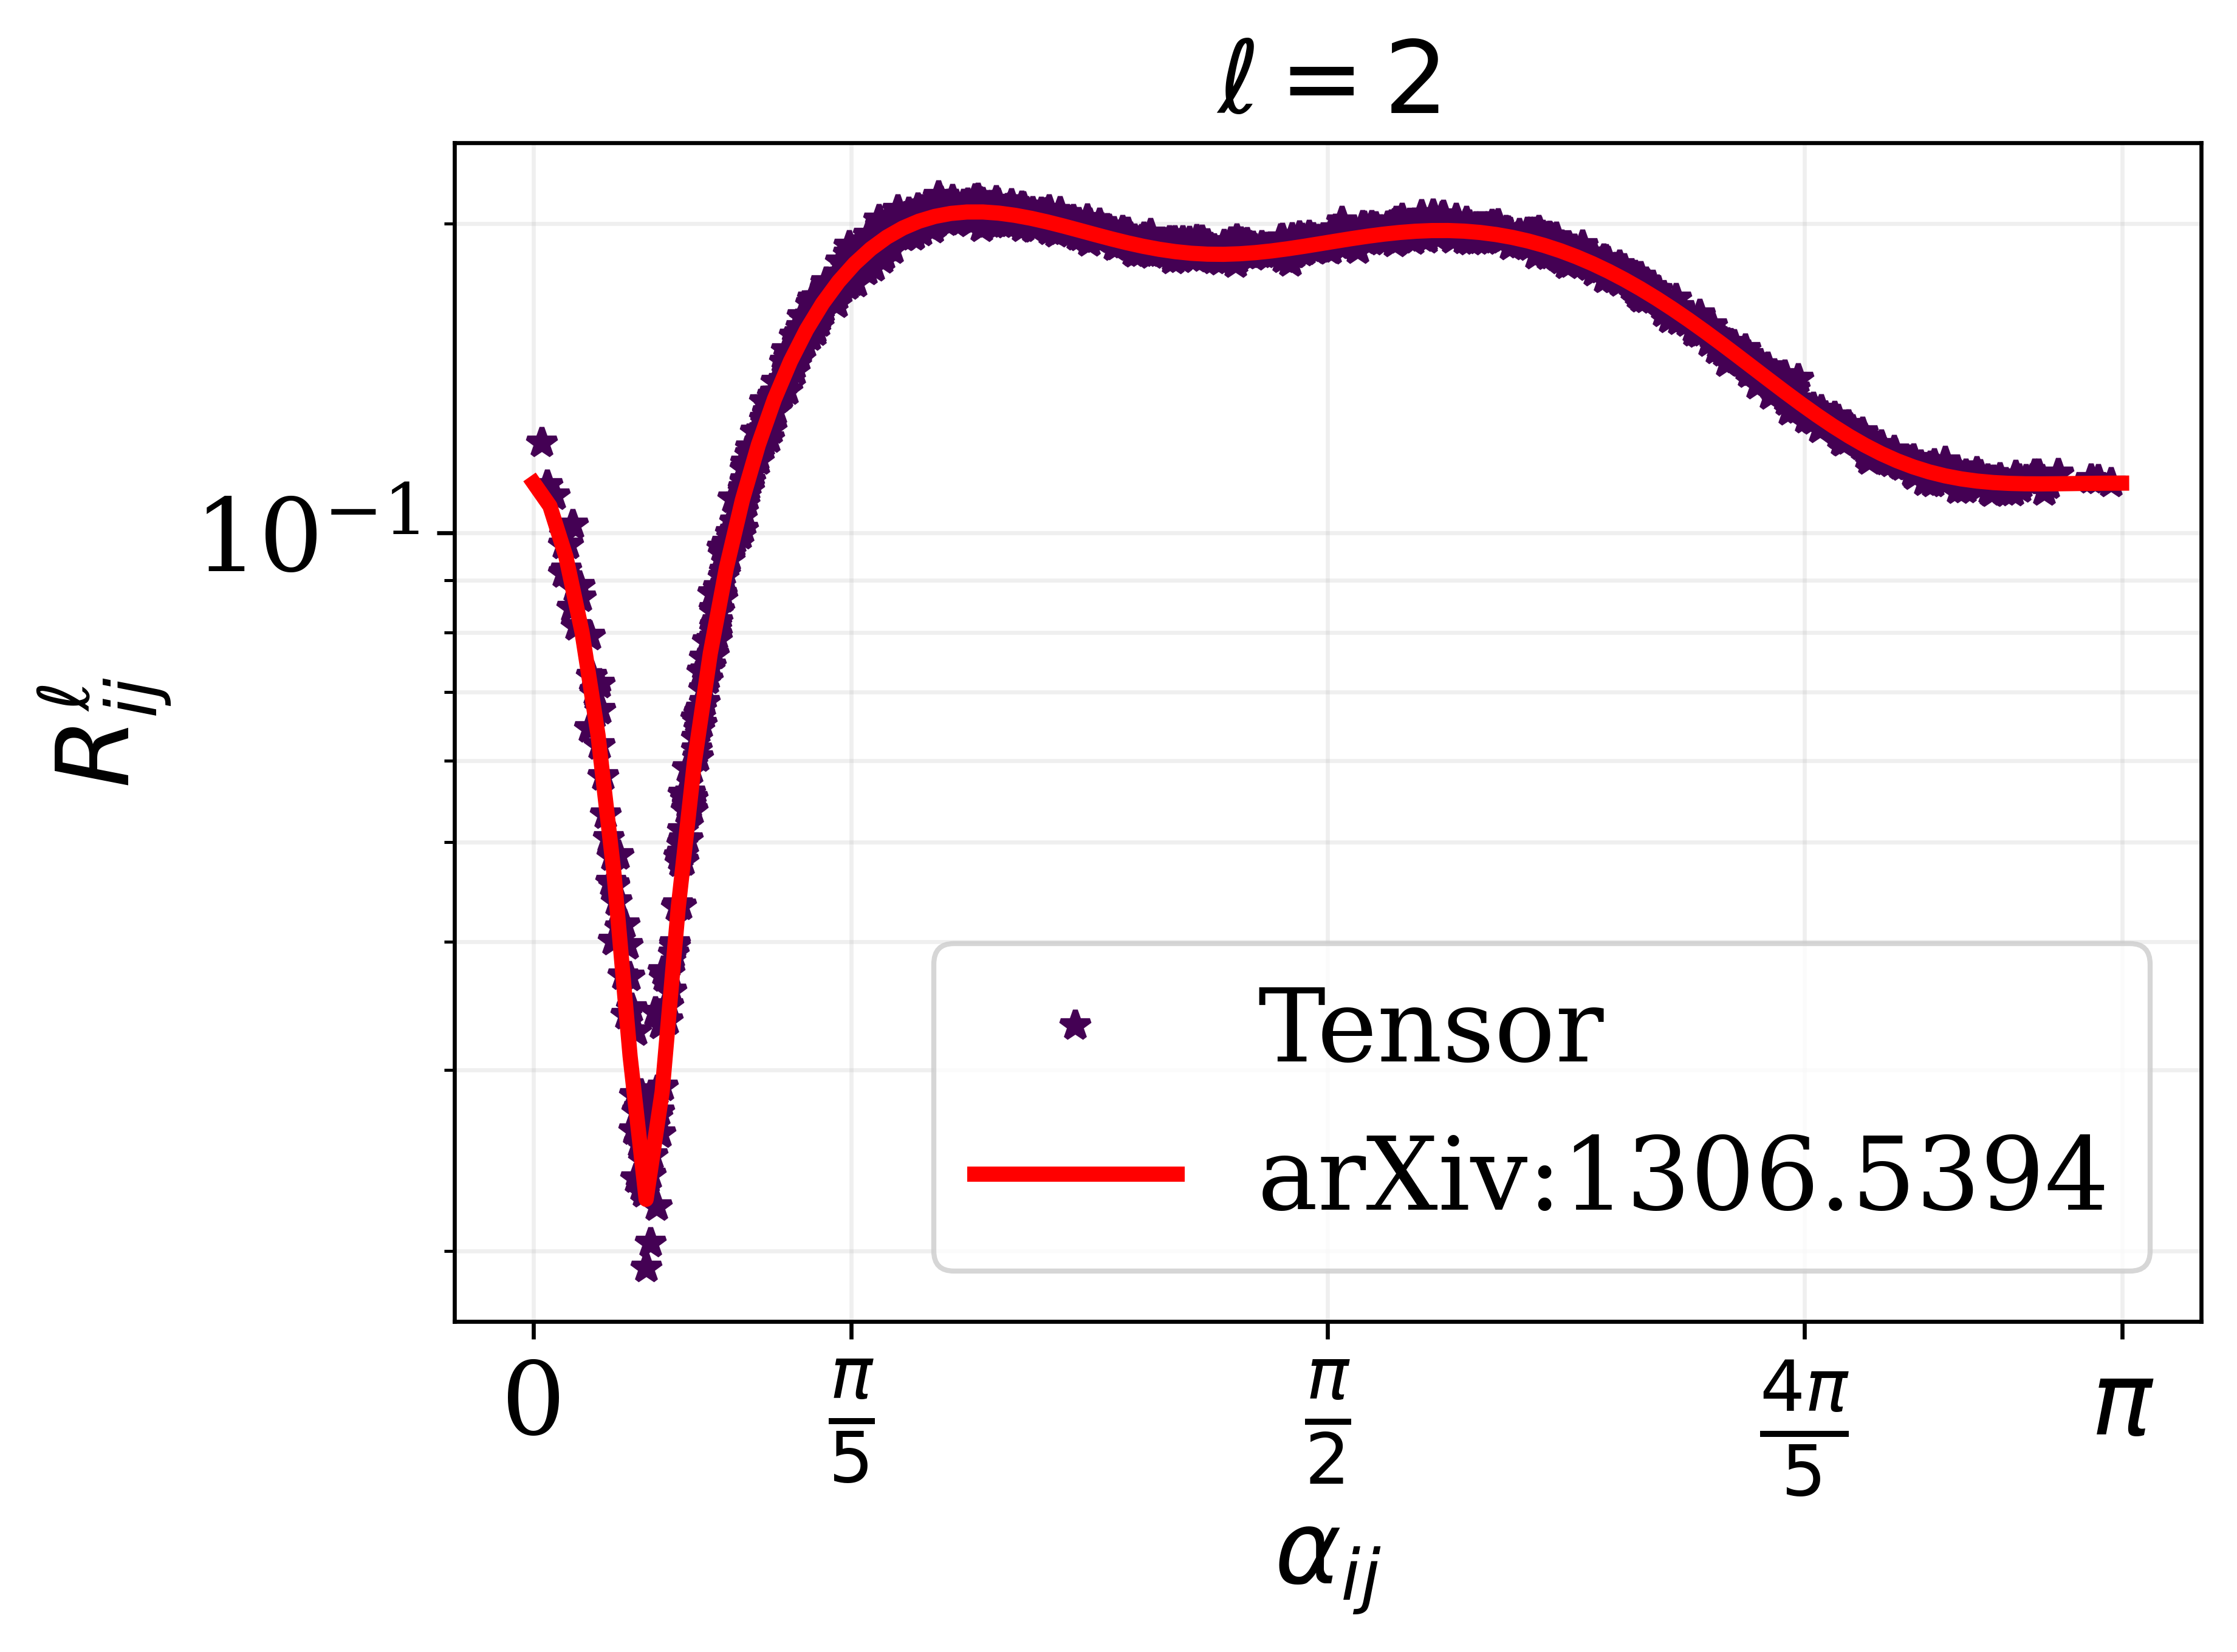

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

plt.semilogy(alpha_ij, np.abs(gamma2_ij_t_10_8), '*', color=colors[0], label='Tensor')
plt.semilogy(alpha, 3*np.sqrt(4*np.pi)/(8*np.pi)*R_2(alpha), color='red', label='arXiv:1306.5394')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$R_{ij}^{\ell}$')
plt.grid(which='both', alpha=0.2)
plt.title(r'$\ell=2$')
plt.xticks(custom_ticks)
plt.legend()
plt.gca().xaxis.set_major_formatter(FuncFormatter(custom_pi_formatter))

plt.tight_layout()
plt.show()


# APLS

Angular Power law integrated sensitivity curve

## Ground Based Detectors


Evaluate the sensitivity of a couple of detector to a GWB signal for a specific multipole ell.

```sens_ell = Sensitivity_ell.PLS_ell(det1, det2, ell, f, pol, psi, fref, snr, Tobs, Cl, shift_angle=None, fI=None, PnI=None, fJ=None, PnJ=None)```


 https://arxiv.org/pdf/2201.08782 eq.4.42 - 4.43

Parameters:
- det1, det2 : str or list of str
    The names of the detectors or the network of detectors to be considered.
    Supported options are:
    - Predefined detector or detector networks such as 'ET triangular', 'LISA', or custom detectors defined as lists with specific parameters.
    - For custom detectors, provide a list with the following elements: ```H=[c, xA, xB, l, name]```
        - c: array_like of length 3 (position of the detector in the Earth-centered frame in meters)
        - xA: array_like of length 3 (unit vector pointing towards the detector in the Earth-centered frame)
        - xB: array_like of length 3 (unit vector pointing towards the detector in the Earth-centered frame)
        - l: float (length of the detector arm in meters)
        - name: str (name of the detector)

- ell (int): Multipole moment.
- f (array): Frequency array.
- pol (float): Polarization.
- psi (float): Polarization angle.
- fref (float): Reference frequency.
- snr (float): Signal-to-noise ratio threshold.
- Tobs (float): Observation time in years.
- Cl (float): Cl parameter for multipole.
- shift_angle (float, optional): Shift angle.
- fI, PnI, fJ, PnJ (array, optional): Frequency and noise power spectral density for custom detectors.

Returns:
- pls: array_like ( power law sensitivity curve  ($h^2 \Omega_{GW}(f)$) )


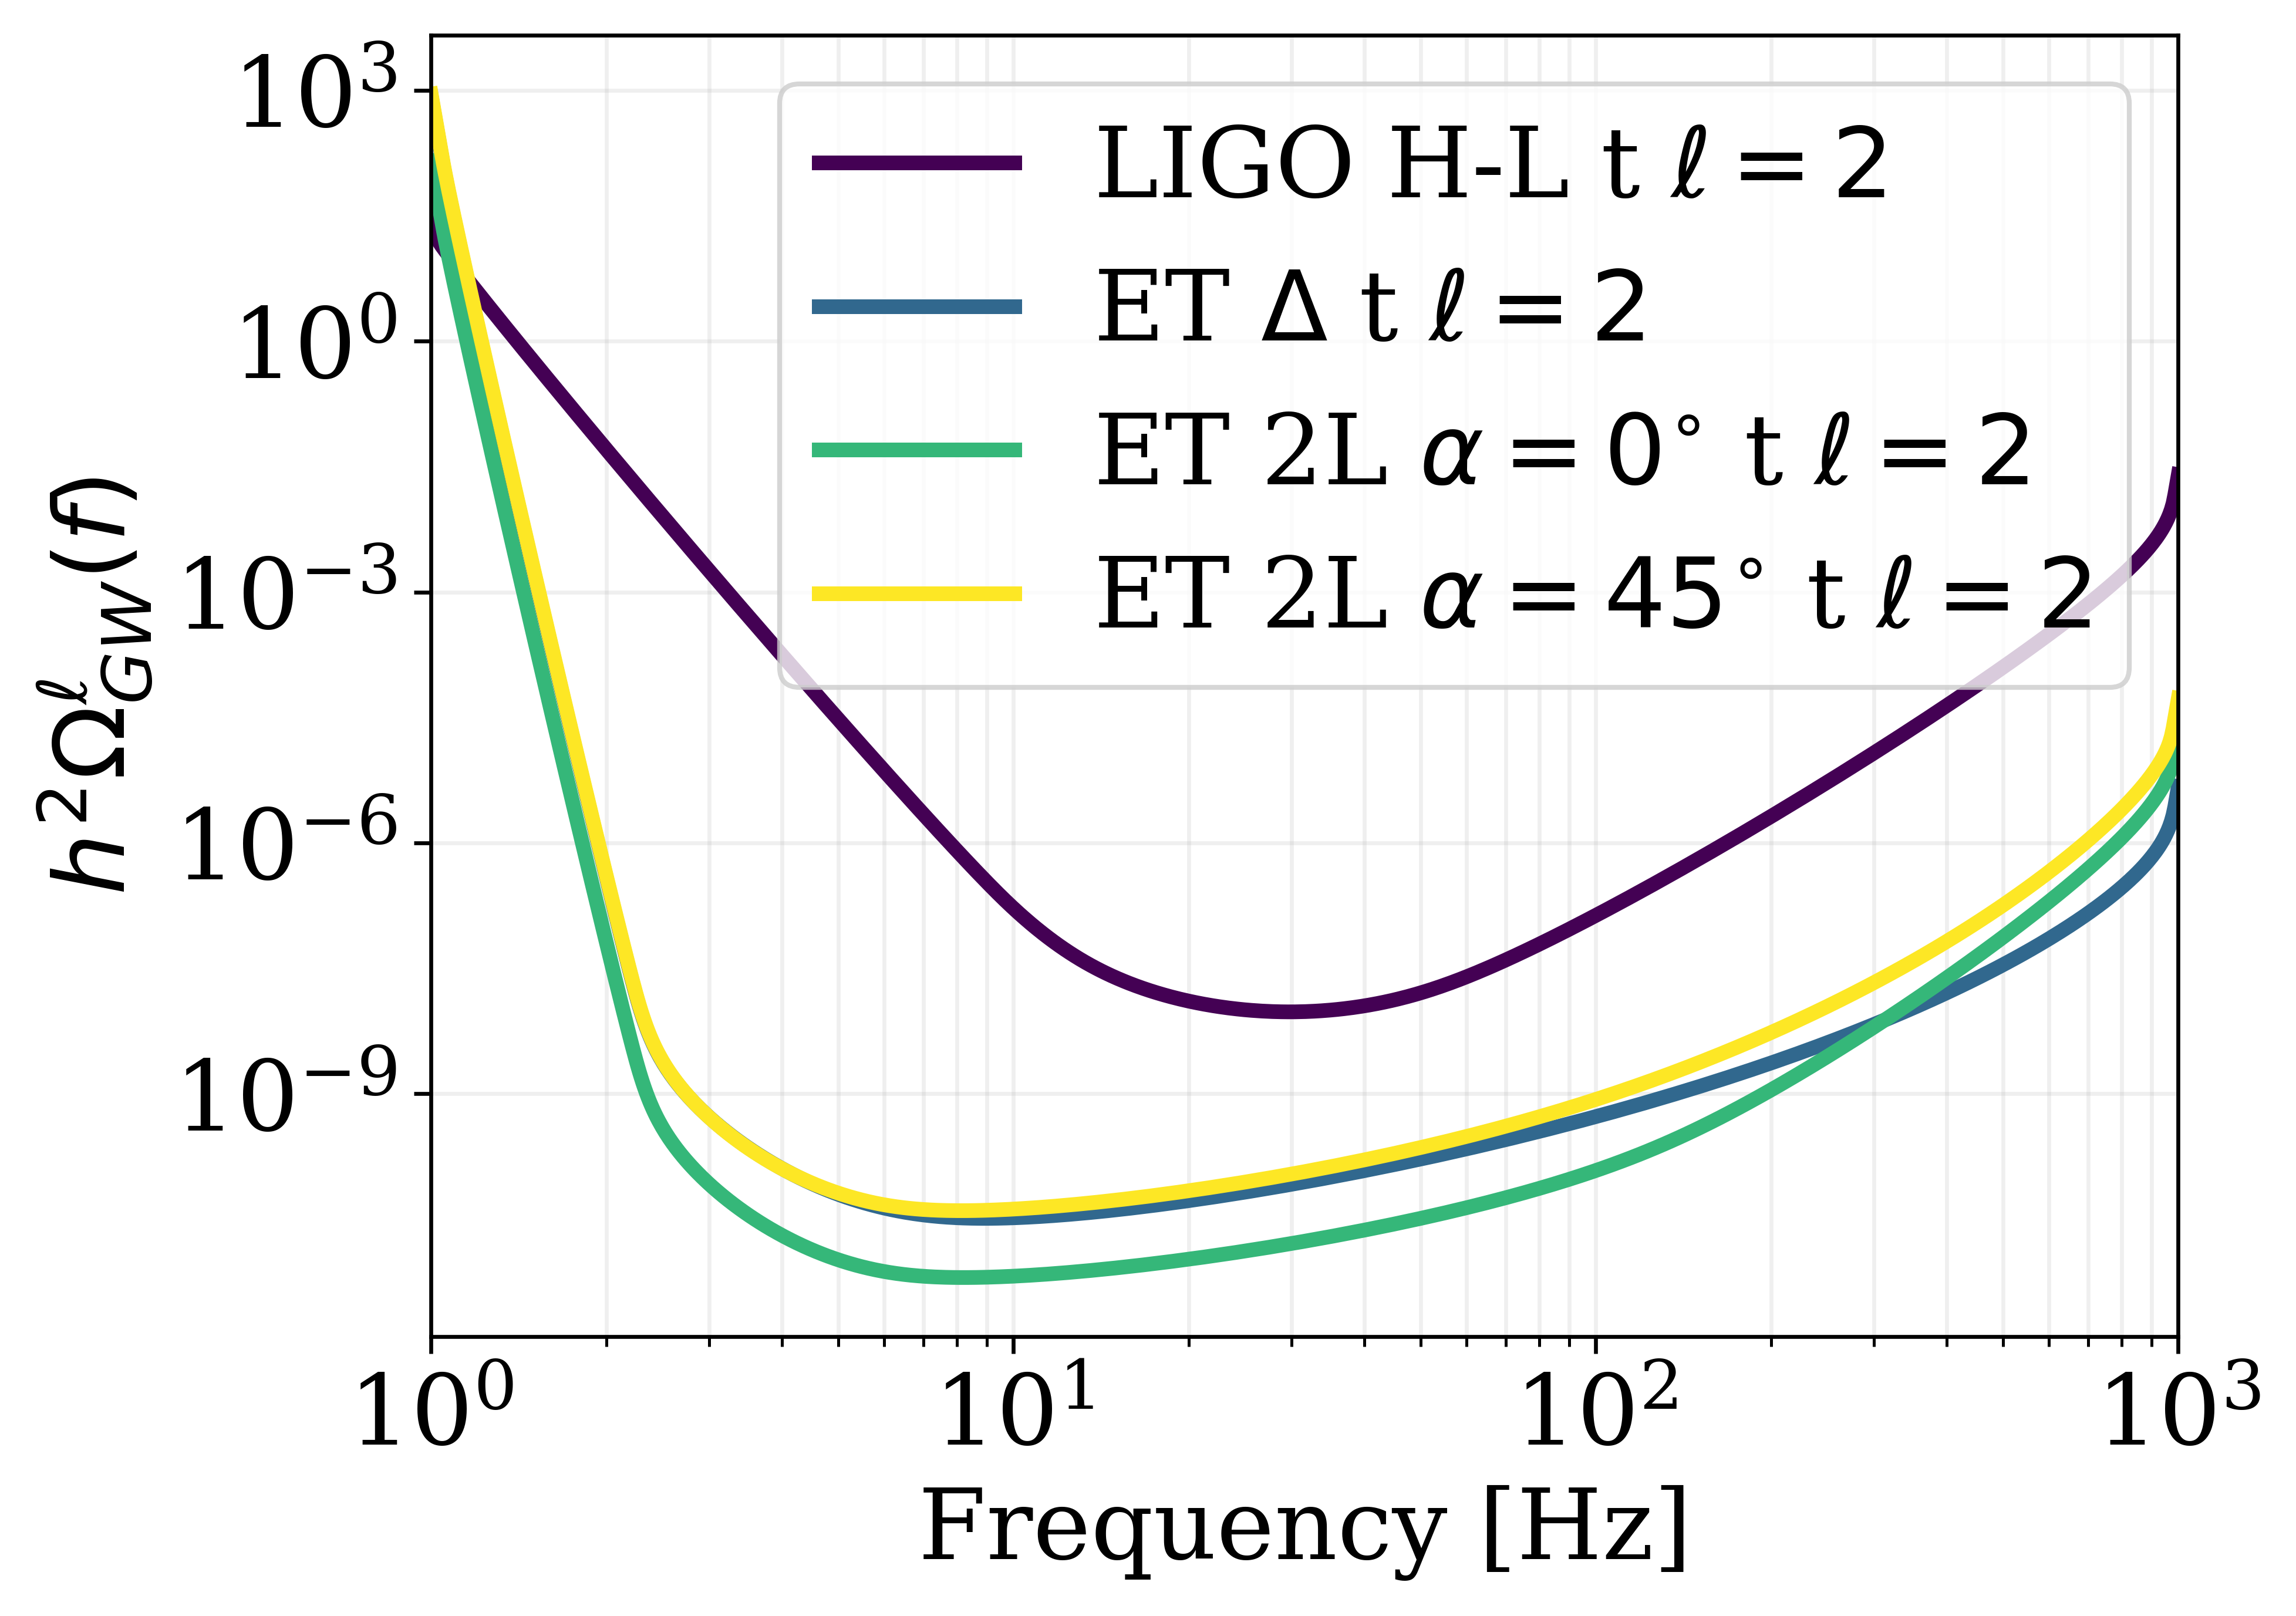

In [22]:
Cl = 1e-3
l=2
Tobs = 1
fref = 10
snr = 1

f = np.logspace(0, 3, 1000)
pls2_LIGO = Sensitivity_ell.APLS_ell('LIGO H', 'LIGO L', l, f, 't', 0, fref, snr, Tobs, Cl)
pls2_ET = Sensitivity_ell.APLS_ell('ET X', 'ET Y', l, f, 't', 0, fref,  snr, Tobs,  Cl)
pls2_ET2L0 = Sensitivity_ell.APLS_ell('ET L1', 'ET L2', l, f, 't', 0,  fref, snr, Tobs, Cl, 0)
pls2_ET2L45 = Sensitivity_ell.APLS_ell('ET L1', 'ET L2', l, f, 't', 0,  fref, snr, Tobs,  Cl, np.pi/4)

cmap = matplotlib.colormaps['viridis']
colors = cmap(np.linspace(0, 1, 4))

plt.plot(f, pls2_LIGO, label=r'LIGO H-L t $\ell=2$', color=colors[0])
plt.plot(f, pls2_ET, label=r'ET $\Delta$ t $\ell=2$', color=colors[1])
plt.plot(f, pls2_ET2L0, label=r'ET 2L $\alpha=0^{\circ}$ t $\ell=2$', color=colors[2])
plt.plot(f, pls2_ET2L45, label=r'ET 2L $\alpha=45^{\circ}$ t $\ell=2$', color=colors[3])
plt.xlabel('Frequency [Hz]')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$h^2 \Omega_{GW}^{\ell}(f)$')
plt.xlim(f.min(), f.max())
plt.grid(which='both', alpha=0.2)
plt.legend()
plt.show()

## LISA

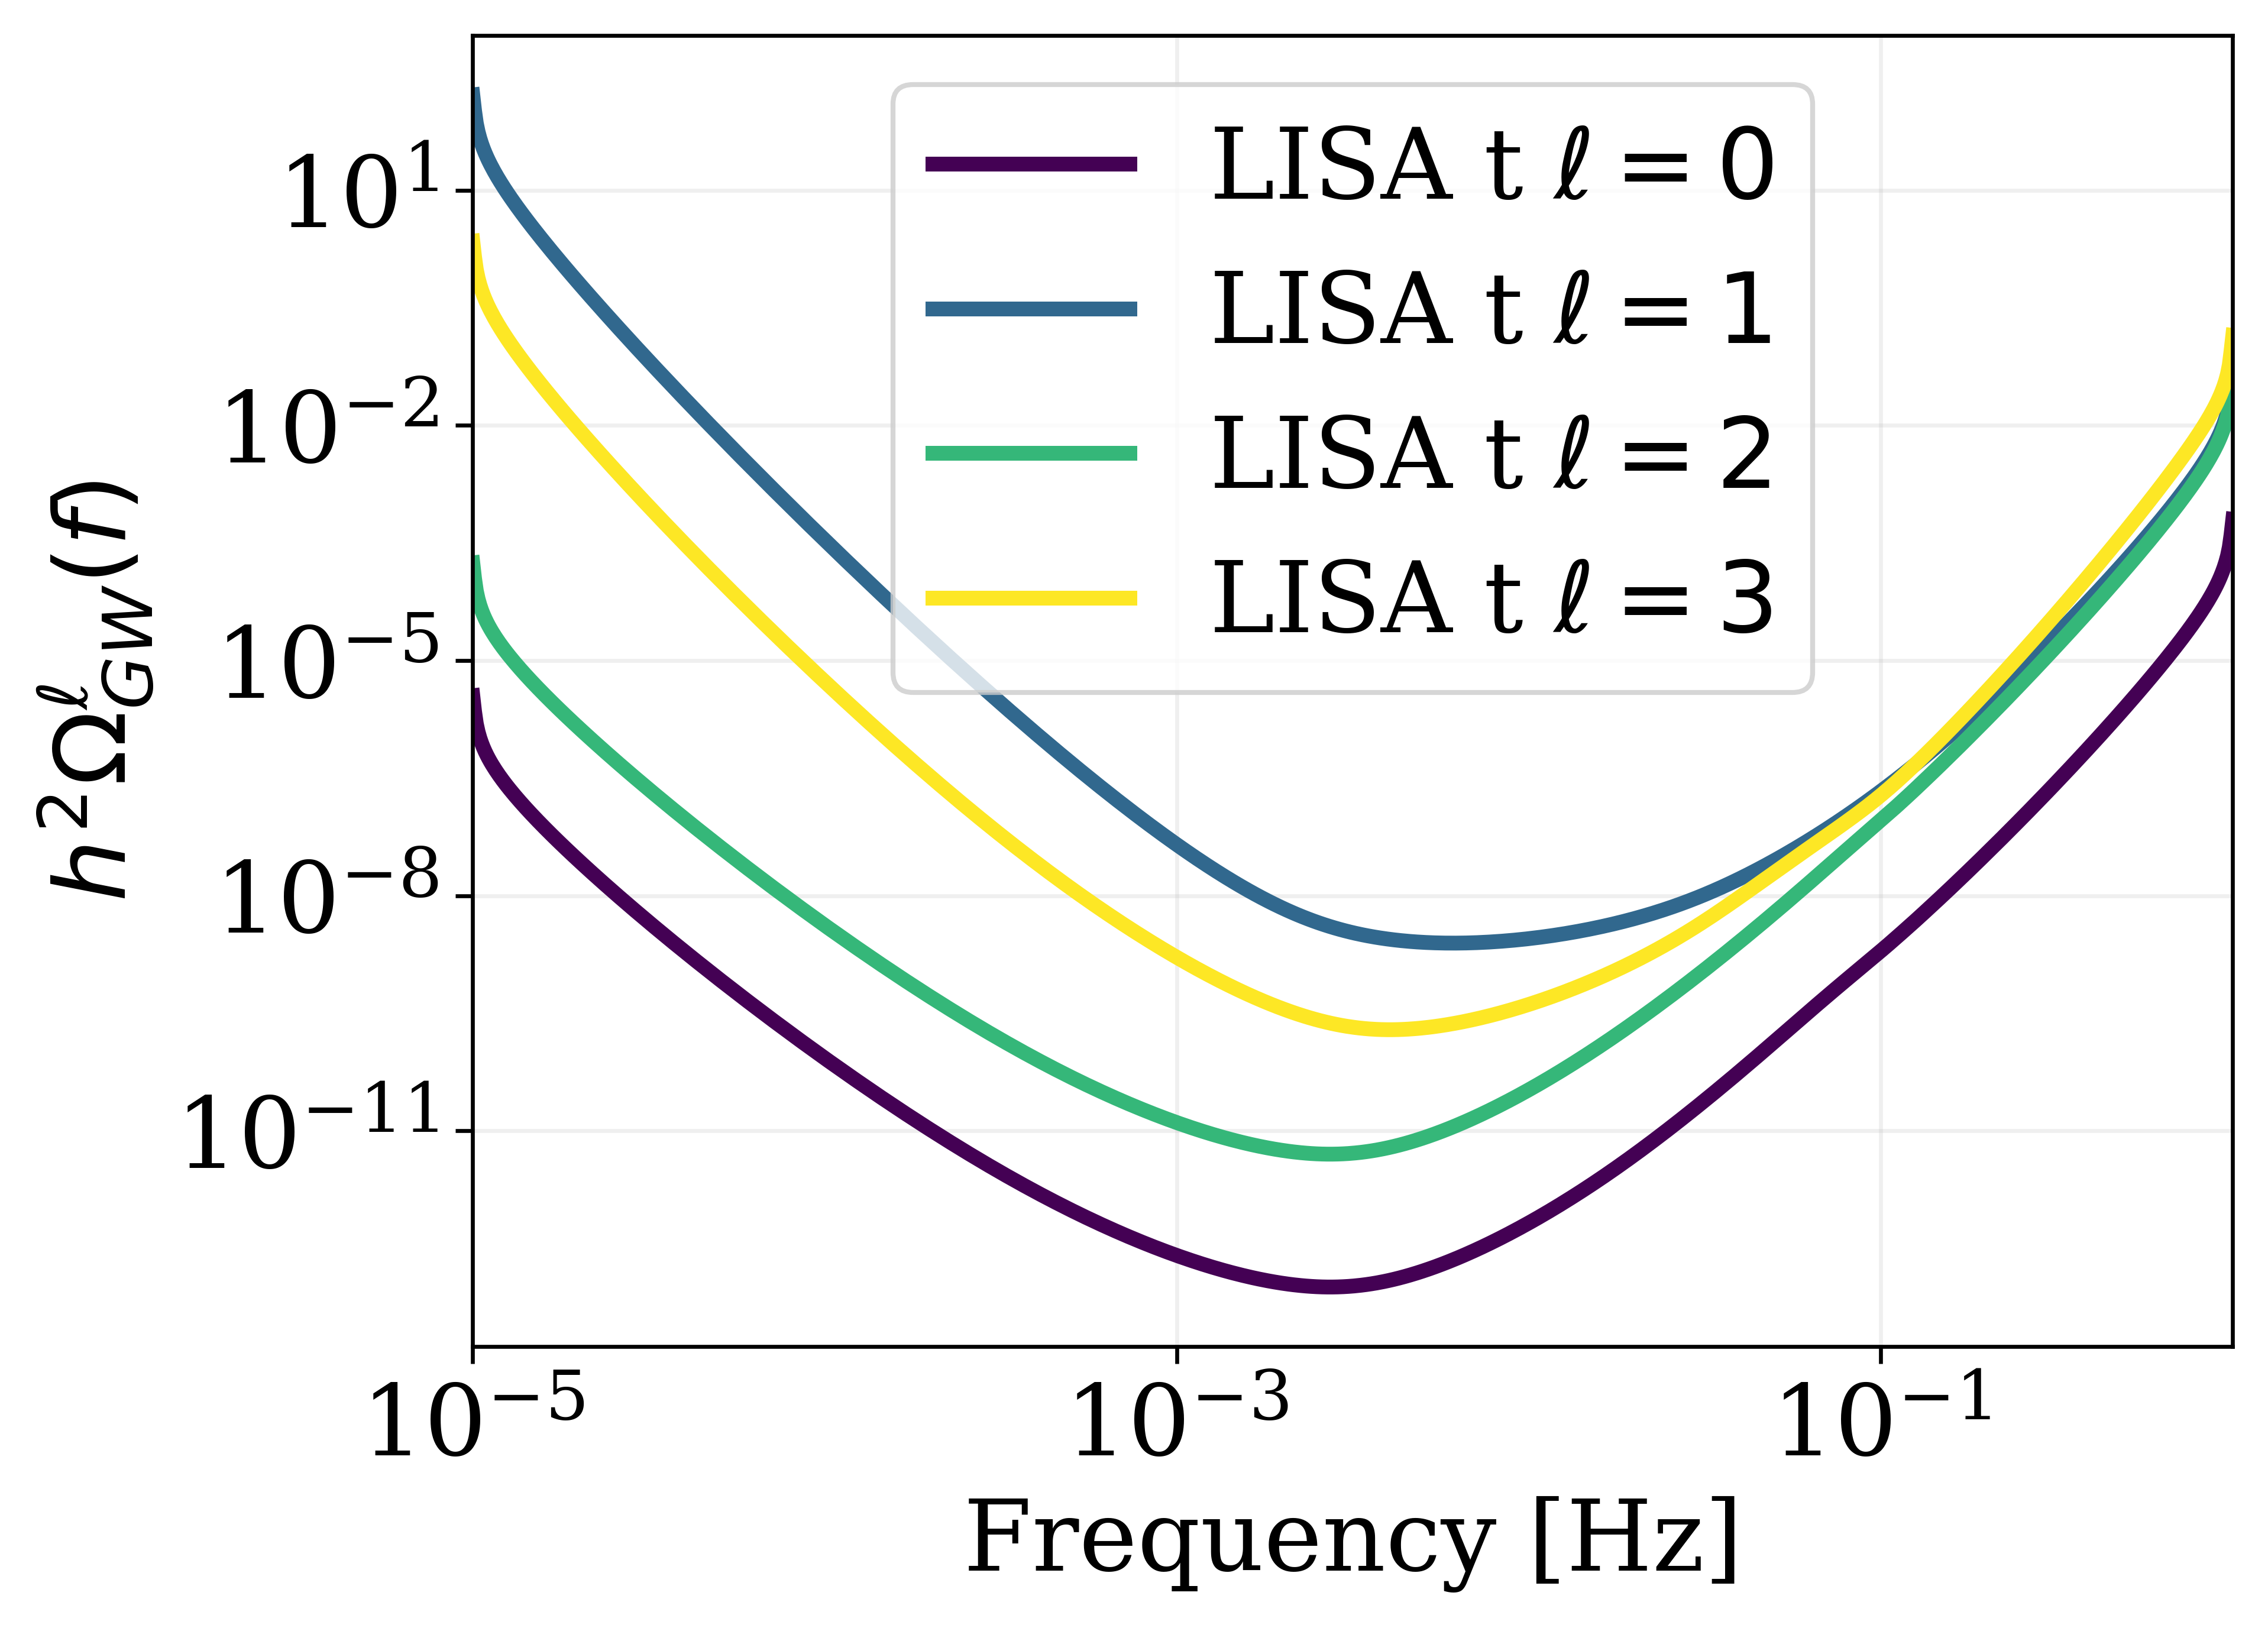

In [23]:
Tobs = 3
snr = 10
f_lisa = np.logspace(-5, 0, 1000)
pls0_LISA = Sensitivity_ell.APLS_ell('LISA', 'Network', 0, f_lisa, 't', 0, 1e-2, snr, Tobs, 1)
pls1_LISA = Sensitivity_ell.APLS_ell('LISA', 'Network', 1, f_lisa, 't', 0, 1e-2, snr, Tobs, 1e-3)
pls2_LISA = Sensitivity_ell.APLS_ell('LISA', 'Network', 2, f_lisa, 't', 0, 1e-2, snr, Tobs, 1e-3)
pls3_LISA = Sensitivity_ell.APLS_ell('LISA', 'Network', 3, f_lisa, 't', 0, 1e-2, snr, Tobs, 1e-3)

cmap = matplotlib.colormaps['viridis']
colors = cmap(np.linspace(0, 1, 4))

plt.figure()
plt.plot(f_lisa, pls0_LISA, label='LISA t $\ell=0$', color=colors[0])
plt.plot(f_lisa, pls1_LISA, label='LISA t $\ell=1$', color=colors[1])
plt.plot(f_lisa, pls2_LISA, label='LISA t $\ell=2$', color=colors[2])
plt.plot(f_lisa, pls3_LISA, label='LISA t $\ell=3$', color=colors[3])
plt.xlabel('Frequency [Hz]')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$h^2 \Omega_{GW}^{\ell}(f)$')
plt.xlim(f_lisa.min(), f_lisa.max())
plt.grid(which='both', alpha=0.2)
plt.legend()


# Pulsar Timing Array

Compute the power law sensitivity curve for NANOGrav pulsars catalog

```pls_PTA = PLS_ell_PTA(ell, f, snr, Tobs, Cl, pol, psi)```

Parameters:
- ell: int (multipole to consider)
- f: array_like (frequency in Hz)
- snr: float (signal to noise ratio)
- Tobs: float (observation time in years)
- Cl: float (Cl parameter for multipole)
- pol: str (polarization: 't' for tensor, 'v' for vector, 's' for scalar, 'I' for intensity, 'V' for circular polarization)
- psi: float (polarization angle)

Return:
- pls: array_like (power law sensitivity curve  ($h^2 \Omega_{GW}(f)$))
       

2025-07-16 14:31:07.163 | DEBUG    | pint.models.binary_ddk:validate:211 - Validating DDK model in ECL coordinates
2025-07-16 14:36:44.658 | DEBUG    | pint.models.binary_ddk:validate:211 - Validating DDK model in ECL coordinates
2025-07-16 14:52:39.813 | DEBUG    | pint.models.binary_ddk:validate:211 - Validating DDK model in ECL coordinates


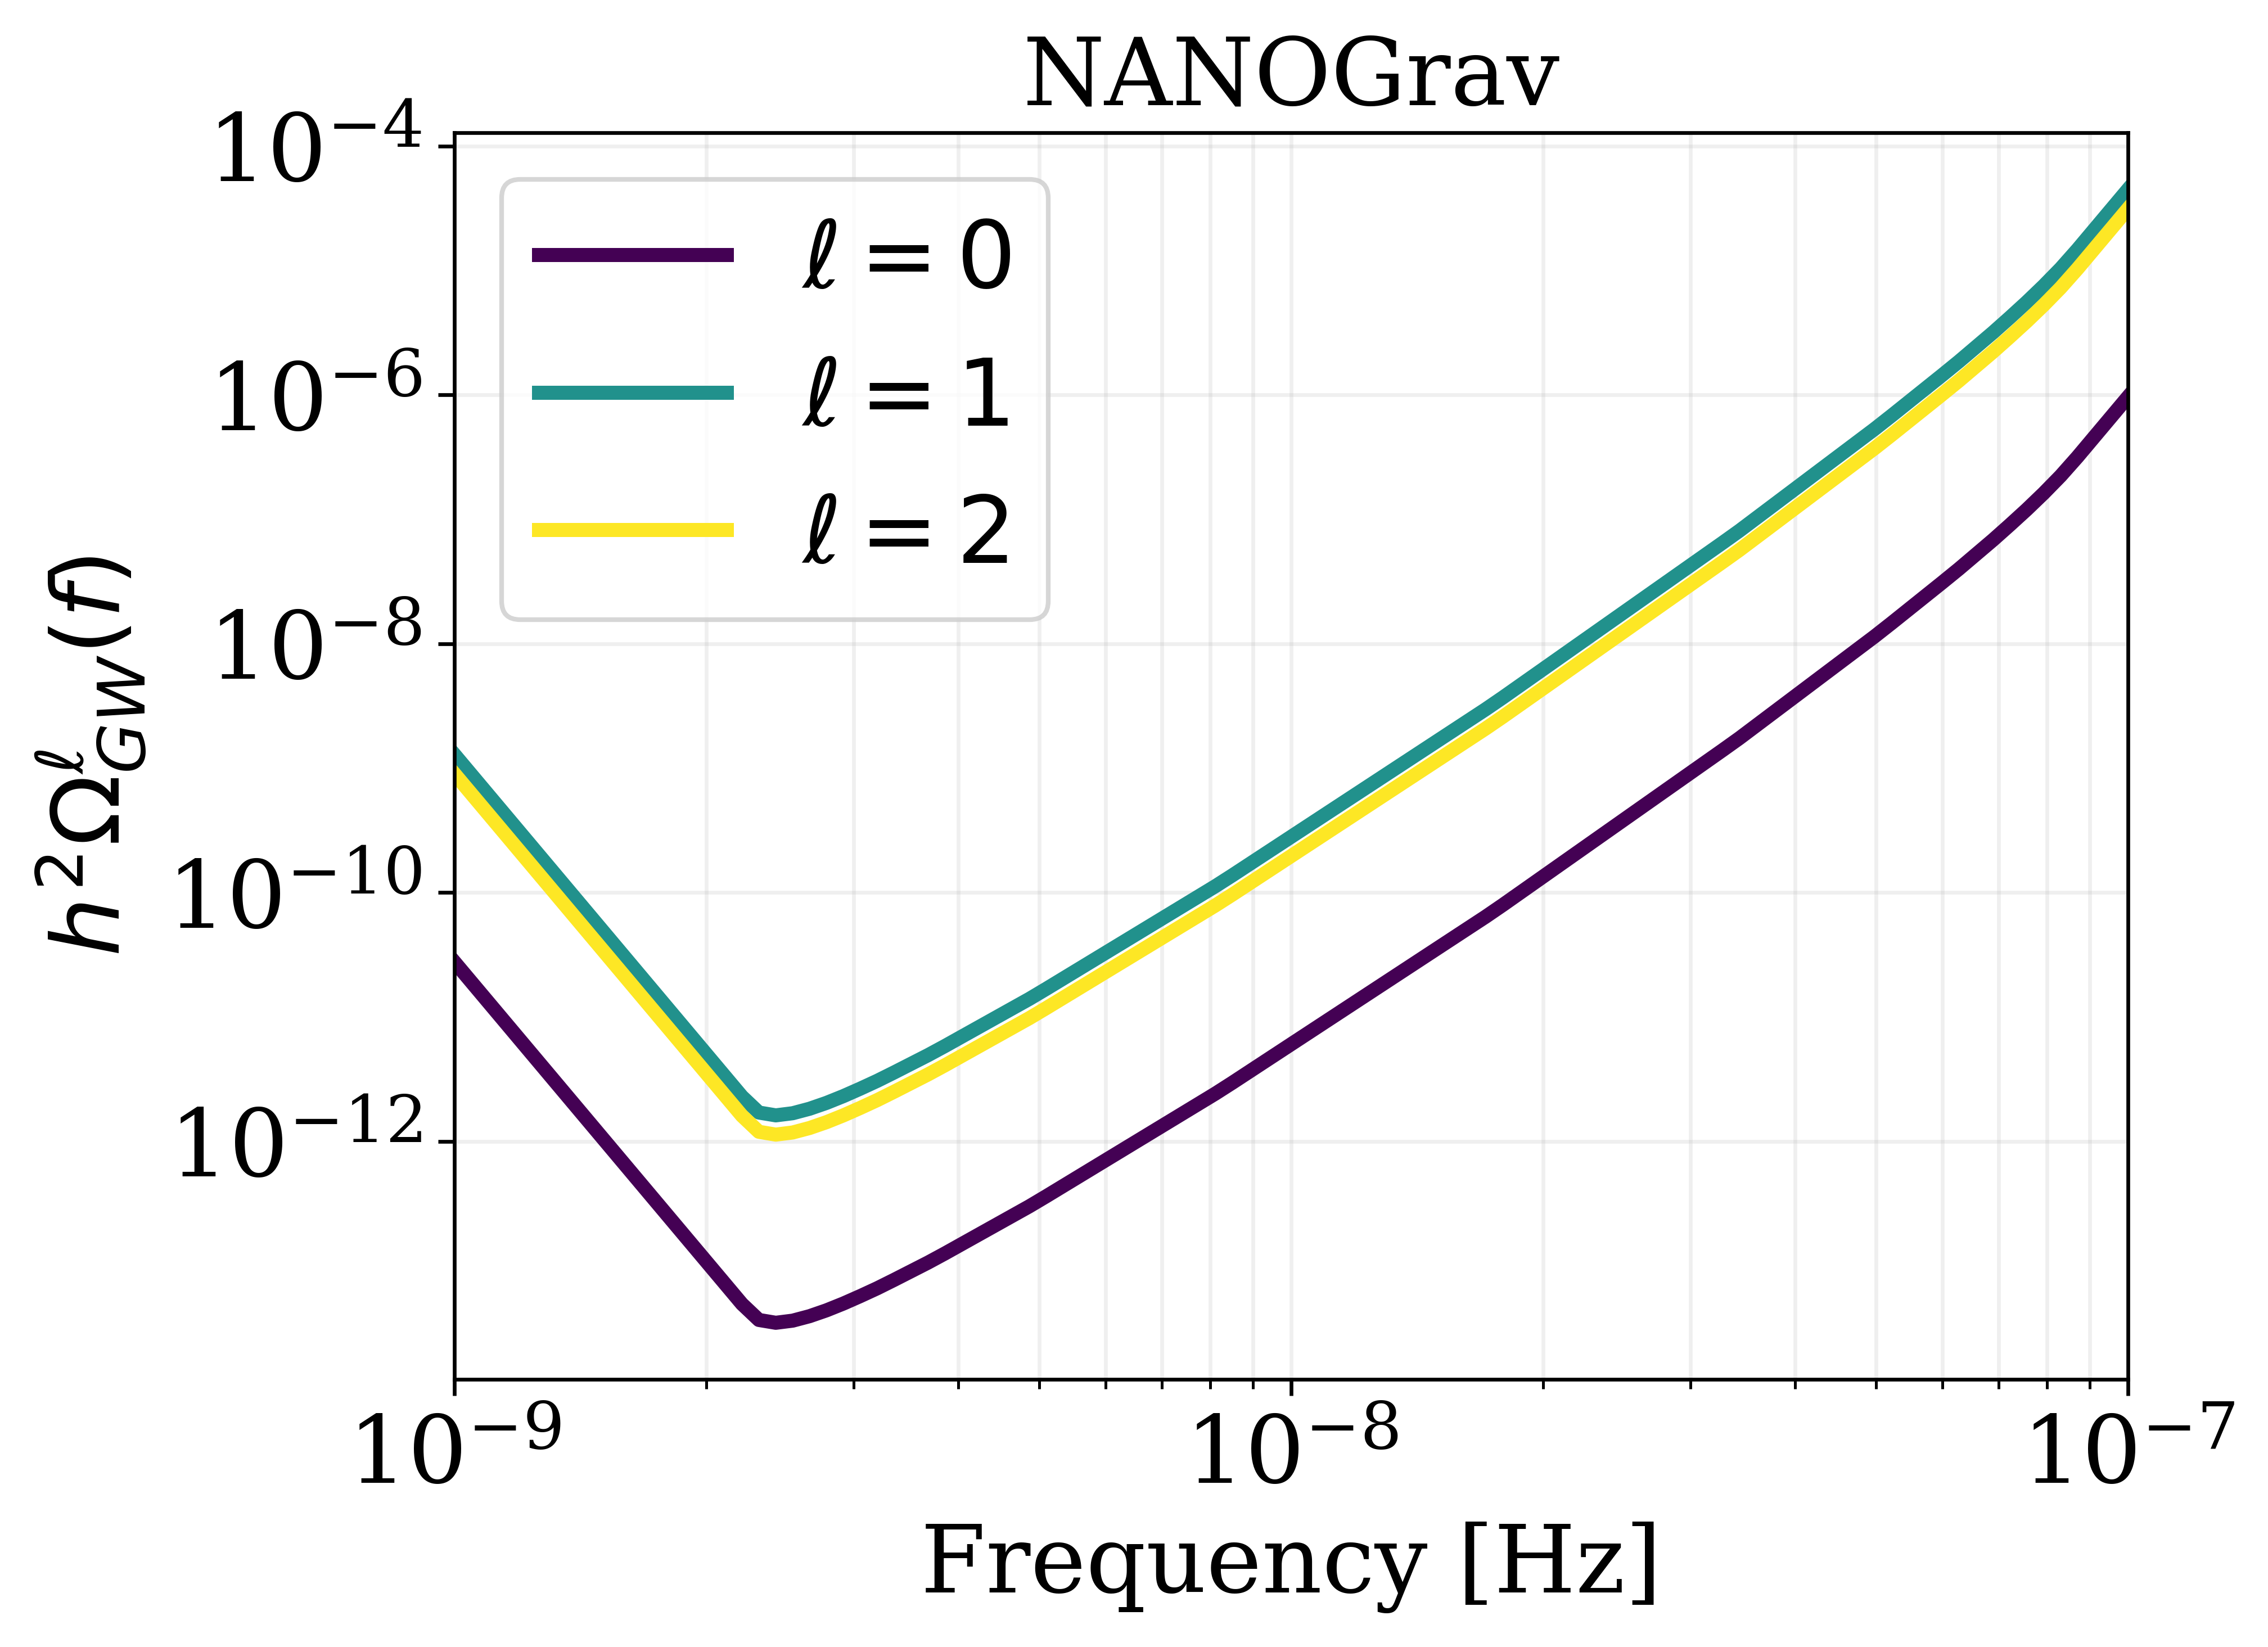

In [24]:
f = np.logspace(-9, -7, 100)
snr = 1
Tobs = 15
psi=0

pls_NANOGrav_0 = Sensitivity_ell.APLS_ell_PTA(0, f, snr, Tobs, 1, 't', psi)
pls_NANOGrav_1 = Sensitivity_ell.APLS_ell_PTA(1, f, snr, Tobs, 1e-3, 't', psi)
pls_NANOGrav_2 = Sensitivity_ell.APLS_ell_PTA(2, f, snr, Tobs, 1e-3, 't', psi)

cmap = matplotlib.colormaps['viridis']
colors = cmap(np.linspace(0, 1, 3))

plt.loglog(f, pls_NANOGrav_0, label=r'$\ell=0$', color=colors[0])
plt.loglog(f, pls_NANOGrav_1, label=r'$\ell=1$', color=colors[1])
plt.loglog(f, pls_NANOGrav_2, label=r'$\ell=2$', color=colors[2])

plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$h^2 \Omega_{GW}^{\ell}(f)$')
plt.xlim(f.min(), f.max())
plt.legend()
plt.title('NANOGrav')
plt.grid(which='both', alpha=0.2)